In [1]:
library(ggplot2)
library(dplyr)
library(reshape2)
library(binom)
library(ungeviz)
library(tidyverse)
library(ggbreak)
library(ggVennDiagram)
library(ggvenn)
library(patchwork)
library(scales)
library(data.table)
library(ggpubr)
library(arrow)
library(readxl)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.8     ✔ purrr   0.3.4
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

ggbreak v0.1.0

If you use ggbreak in published research, please cite the following
paper:

S Xu, M Chen, T Feng, L Zhan, L Zhou, G Yu. Use ggbreak to effectively
utilize plotting space to deal with large datasets and outliers.
Frontiers in Genetics. 2021, 12:774846. doi: 10.3389/fgene.2021.774846


Loading required package: grid


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following obj

# Constants

In [2]:
pl_theme = theme(plot.title = element_text(size = 20, face = "bold"), 
          axis.text=element_text(size=18),
          axis.title=element_text(size=20),
          legend.text = element_text(size=18),
          legend.title = element_text(size=20),
          strip.text = element_text(size=18)
         )
simple_annot_names = c('non-genic', 'putative regulatory', 'coding')

In [3]:
annot_colors <- c(
    "LoF" = "#DE3F2E",
    "missense" = "#FDD384",
    "synonymous" = "#E5E5AB",
    "UTR3" = "#807DBA",
    "UTR5" = "#BCBDDC",
    "promoter" = "#08519C",
    "CRE" = "#4292C6",
    "conserved" = "grey",
    "non-genic" = "#C6DBEF"
)
simple_annot_colors <- c(
    "coding" = "#FDD384",
    "putative regulatory" = "#08519C",
    "non-genic" = "#C6DBEF"
)
method_colors <- c(
    "ABF" = "#E69F00",
    "COJO-ABF" = "#56B4E9",
    "SuSiE" = "#009E73",
    "FINEMAP" = "#0072B2",
    "SuSiE-inf" = "#D55E00",
    "FINEMAP-inf" = "#CC79A7",
    "minPIP" = "#FFDB6D",
    "minPIP-inf" = "#FC4E07"
)
pheno_colors <- c(
    "LDLC" = '#083647',
    "ALP" = '#5E4FA2',
    "HbA1c" = '#3F96B7',
    "Lym" = '#88CFA4',
    "Plt" = '#D7EF9B',
    "RBC" = 'yellow',
    "eGFR" = '#FDD380',
    "IGF1" = '#F88D51',
    "eBMD" = '#DC494C',
    "Height" = '#9E0142'
)
method_shapes <- c(
    "SuSiE" = 19,
    "SuSiE-inf" = 1,
    "FINEMAP" = 15,
    "FINEMAP-inf" = 0,
    "minPIP" = 17,
    "minPIP-inf" = 2
)
sim_colors <- c(
    "Ideal" = "#a0ddff",
    "Baseline misspecification" = "#758ecd",
    "Moderate stratification w/ BOLT" = "#ec9192",
    "Moderate non-sparsity" = "#729ea1",
    "High non-sparsity" = "#b5bd89",
    "Very high non-sparsity" = "#dfbe99",
    "No large effects" = "#ebbb5c",
    "Severe stratification w/ BOLT"="#8CBFAF",
    "Moderate stratification w/ OLS"="#023778",
    "Severe stratification w/ OLS"="#4281A4"
)

# Fig. 1

In [4]:
# Aggregated RFR plot
all_rfr = read_excel("Supplementary Tables.xlsx", sheet = 1)
all_rfr[all_rfr=='Simulation'] = 'Ideal simulation'
all_rfr$segment_legend='EPN'
# Compute Binomial proportion SD
all_rfr$std = sqrt((all_rfr$rfr)*(all_rfr$n_highpip)*(1-all_rfr$rfr))/all_rfr$n_highpip
# Filter to aggregated RFR
selected_method_names = c('SuSiE','FINEMAP')
data_to_plot = all_rfr %>% filter(trait=='agg') %>% filter(method_name %in% selected_method_names)
data_to_plot$method_name <- factor(data_to_plot$method_name, levels = selected_method_names)
# Compute EPN line segment positions
num_methods = length(selected_method_names)
barwidth = 0.85/num_methods
pos_dodge = 1
xstart = c(seq(1-barwidth*num_methods/2,1+barwidth*num_methods/2-barwidth,length.out=num_methods),
  seq(1-barwidth*num_methods/2+pos_dodge, 1+barwidth*num_methods/2-barwidth+pos_dodge, length.out=num_methods))
xend = c(seq(1-barwidth*num_methods/2+barwidth,1+barwidth*num_methods/2,length.out=num_methods),
  seq(1-barwidth*num_methods/2+barwidth+pos_dodge,1+barwidth*num_methods/2+pos_dodge,length.out=num_methods))
# Plot
pl_rfr = ggplot(data=data_to_plot, aes(x=data.type, y=rfr, fill=method_name)) +
    geom_bar(position=position_dodge(), color='black', stat="identity",width=0.85) + 
    geom_segment(data=data_to_plot, aes(x=xstart, y=epn, 
                 xend=xend, yend=epn, 
                 color=method_name,linetype=`segment_legend`), 
                 size=0.8,color='black',inherit.aes = FALSE)+
    geom_errorbar(aes(ymin=rfr-std, ymax=rfr+std),position=position_dodge(.85),width=0.2)+
    ylab(label = "Replication failure rate")+
    scale_linetype_manual("EPN",values=c("EPN"=1))+
    scale_fill_manual(values=method_colors[selected_method_names])+
    pl_theme + theme(axis.title.x = element_blank(),
                     legend.title = element_blank())

New names:
• `` -> `...1`


In [7]:
# Trait separated RFR plot
# Compute EPN line segment positions
pos_dodge = 0.85
num_traits = 10
traits_xstart = c(seq(1-barwidth*num_methods/2,1*num_traits+barwidth*num_methods/2-barwidth-barwidth,length.out=num_traits),
  seq(1-barwidth*num_methods/2+barwidth, 1*num_traits+barwidth*num_methods/2-barwidth+barwidth-barwidth, length.out=num_traits))
traits_xend = c(seq(1-barwidth*num_methods/2+barwidth,1*num_traits+barwidth*num_methods/2-barwidth,length.out=num_traits),
  seq(1-barwidth*num_methods/2+barwidth+barwidth,1*num_traits+barwidth*num_methods/2+barwidth-barwidth,length.out=num_traits))
# Filter to trait only RFR results
traits_data_to_plot <- all_rfr %>% filter(method_name %in% selected_method_names) %>% filter(trait != 'agg')
traits_data_to_plot$method <- factor(traits_data_to_plot$method_name, levels = selected_method_names)
# Plot
pl_trait_rfr = ggplot(data=traits_data_to_plot, 
       aes(x=forcats::fct_reorder(trait, rfr, .desc = TRUE), y=rfr, fill=method_name)) +
    geom_bar(position=position_dodge(), color='black', stat="identity",width=0.85) + 
    geom_segment(data=traits_data_to_plot, aes(x=traits_xstart, y=epn, 
                 xend=traits_xend, yend=epn, 
                 color=method_name,linetype=`segment_legend`), 
                 size=0.8,color='black',inherit.aes = FALSE)+
    geom_errorbar(aes(ymin=rfr-std, ymax=rfr+std),position=position_dodge(.85),width=0.2)+
    ylab(label = "Replication failure rate")+
    scale_linetype_manual("EPN",values=c("EPN"=1))+
    scale_fill_manual(values=method_colors[selected_method_names])+
    pl_theme + theme(legend.title=element_blank(),
                     axis.title.x = element_blank())

In [8]:
# Aggregated functional enrichment plot for SuSiE + FINEMAP
func_enrich = read_excel("Supplementary Tables.xlsx", sheet = 2)
selected_methods = c('SuSiE','FINEMAP')
selected_groups = c('Non-replicating','Replicated','Background')
# Combine annotation groups
func_enrich_selected = (func_enrich %>% filter(method_name %in% selected_methods)
                            %>% filter(type %in% selected_groups)
                            %>% mutate(coding=(LoF + missense))
                            %>% mutate("putative regulatory"=(synonymous+UTR3+UTR5+promoter+CRE+conserved))
                            %>% dplyr::select(type, coding, "putative regulatory", "non-genic"))
# aggregate methods
agg_methods <- func_enrich_selected %>% group_by(type) %>% summarise(across(all_of(simple_annot_names), sum))
data <- as.data.frame(agg_methods)
melted_data <-  reshape2::melt(data , id.vars = c("type"), measure.vars = simple_annot_names)
data <- group_by(melted_data,type)
data <- mutate(data, prop = value / sum(value), 
               std = sqrt(sum(value)*(value/sum(value))*(1-(value/sum(value))))/sum(value),
               sd_pos = cumsum(prop))
data$type<-factor(data$type, levels= selected_groups)
data$variable <- factor(data$variable,levels=simple_annot_names)
# plot
pl_func_enrich <- qplot(x = type, y = prop, fill = variable, data = data, geom = "col") +
    geom_errorbar(aes(x=type,ymin=1-prop+std,ymax=1-prop-std),width=.1, 
              data=data %>% filter(variable=='non-genic'),
              inherit.aes = FALSE)+
    ggtitle('SuSiE and FINEMAP') +
    scale_fill_manual(values = simple_annot_colors) +
    scale_x_discrete(labels=c("Non-replicating" = "Non-replicating\n ", "1" = "Dose 1",
                              "2" = "Dose 2"))
    pl_theme + theme(plot.title = element_text(hjust=0.4),
                     axis.title.y=element_blank(),
                     axis.title.x=element_blank()) + 
    coord_flip() +guides(fill=guide_legend(title="Categories")) 

New names:
• `` -> `...1`


In [20]:
func_enrich_selected %>% group_by(type) %>%
    summarise('non-genic' = sum(`non-genic`),
              coding = sum(coding),
              'putative regulatory' = sum(`putative regulatory`))

type,non-genic,coding,putative regulatory
<chr>,<dbl>,<dbl>,<dbl>
Background,42118296,629063,9495237
Non-replicating,74,5,37
Replicated,180,209,314


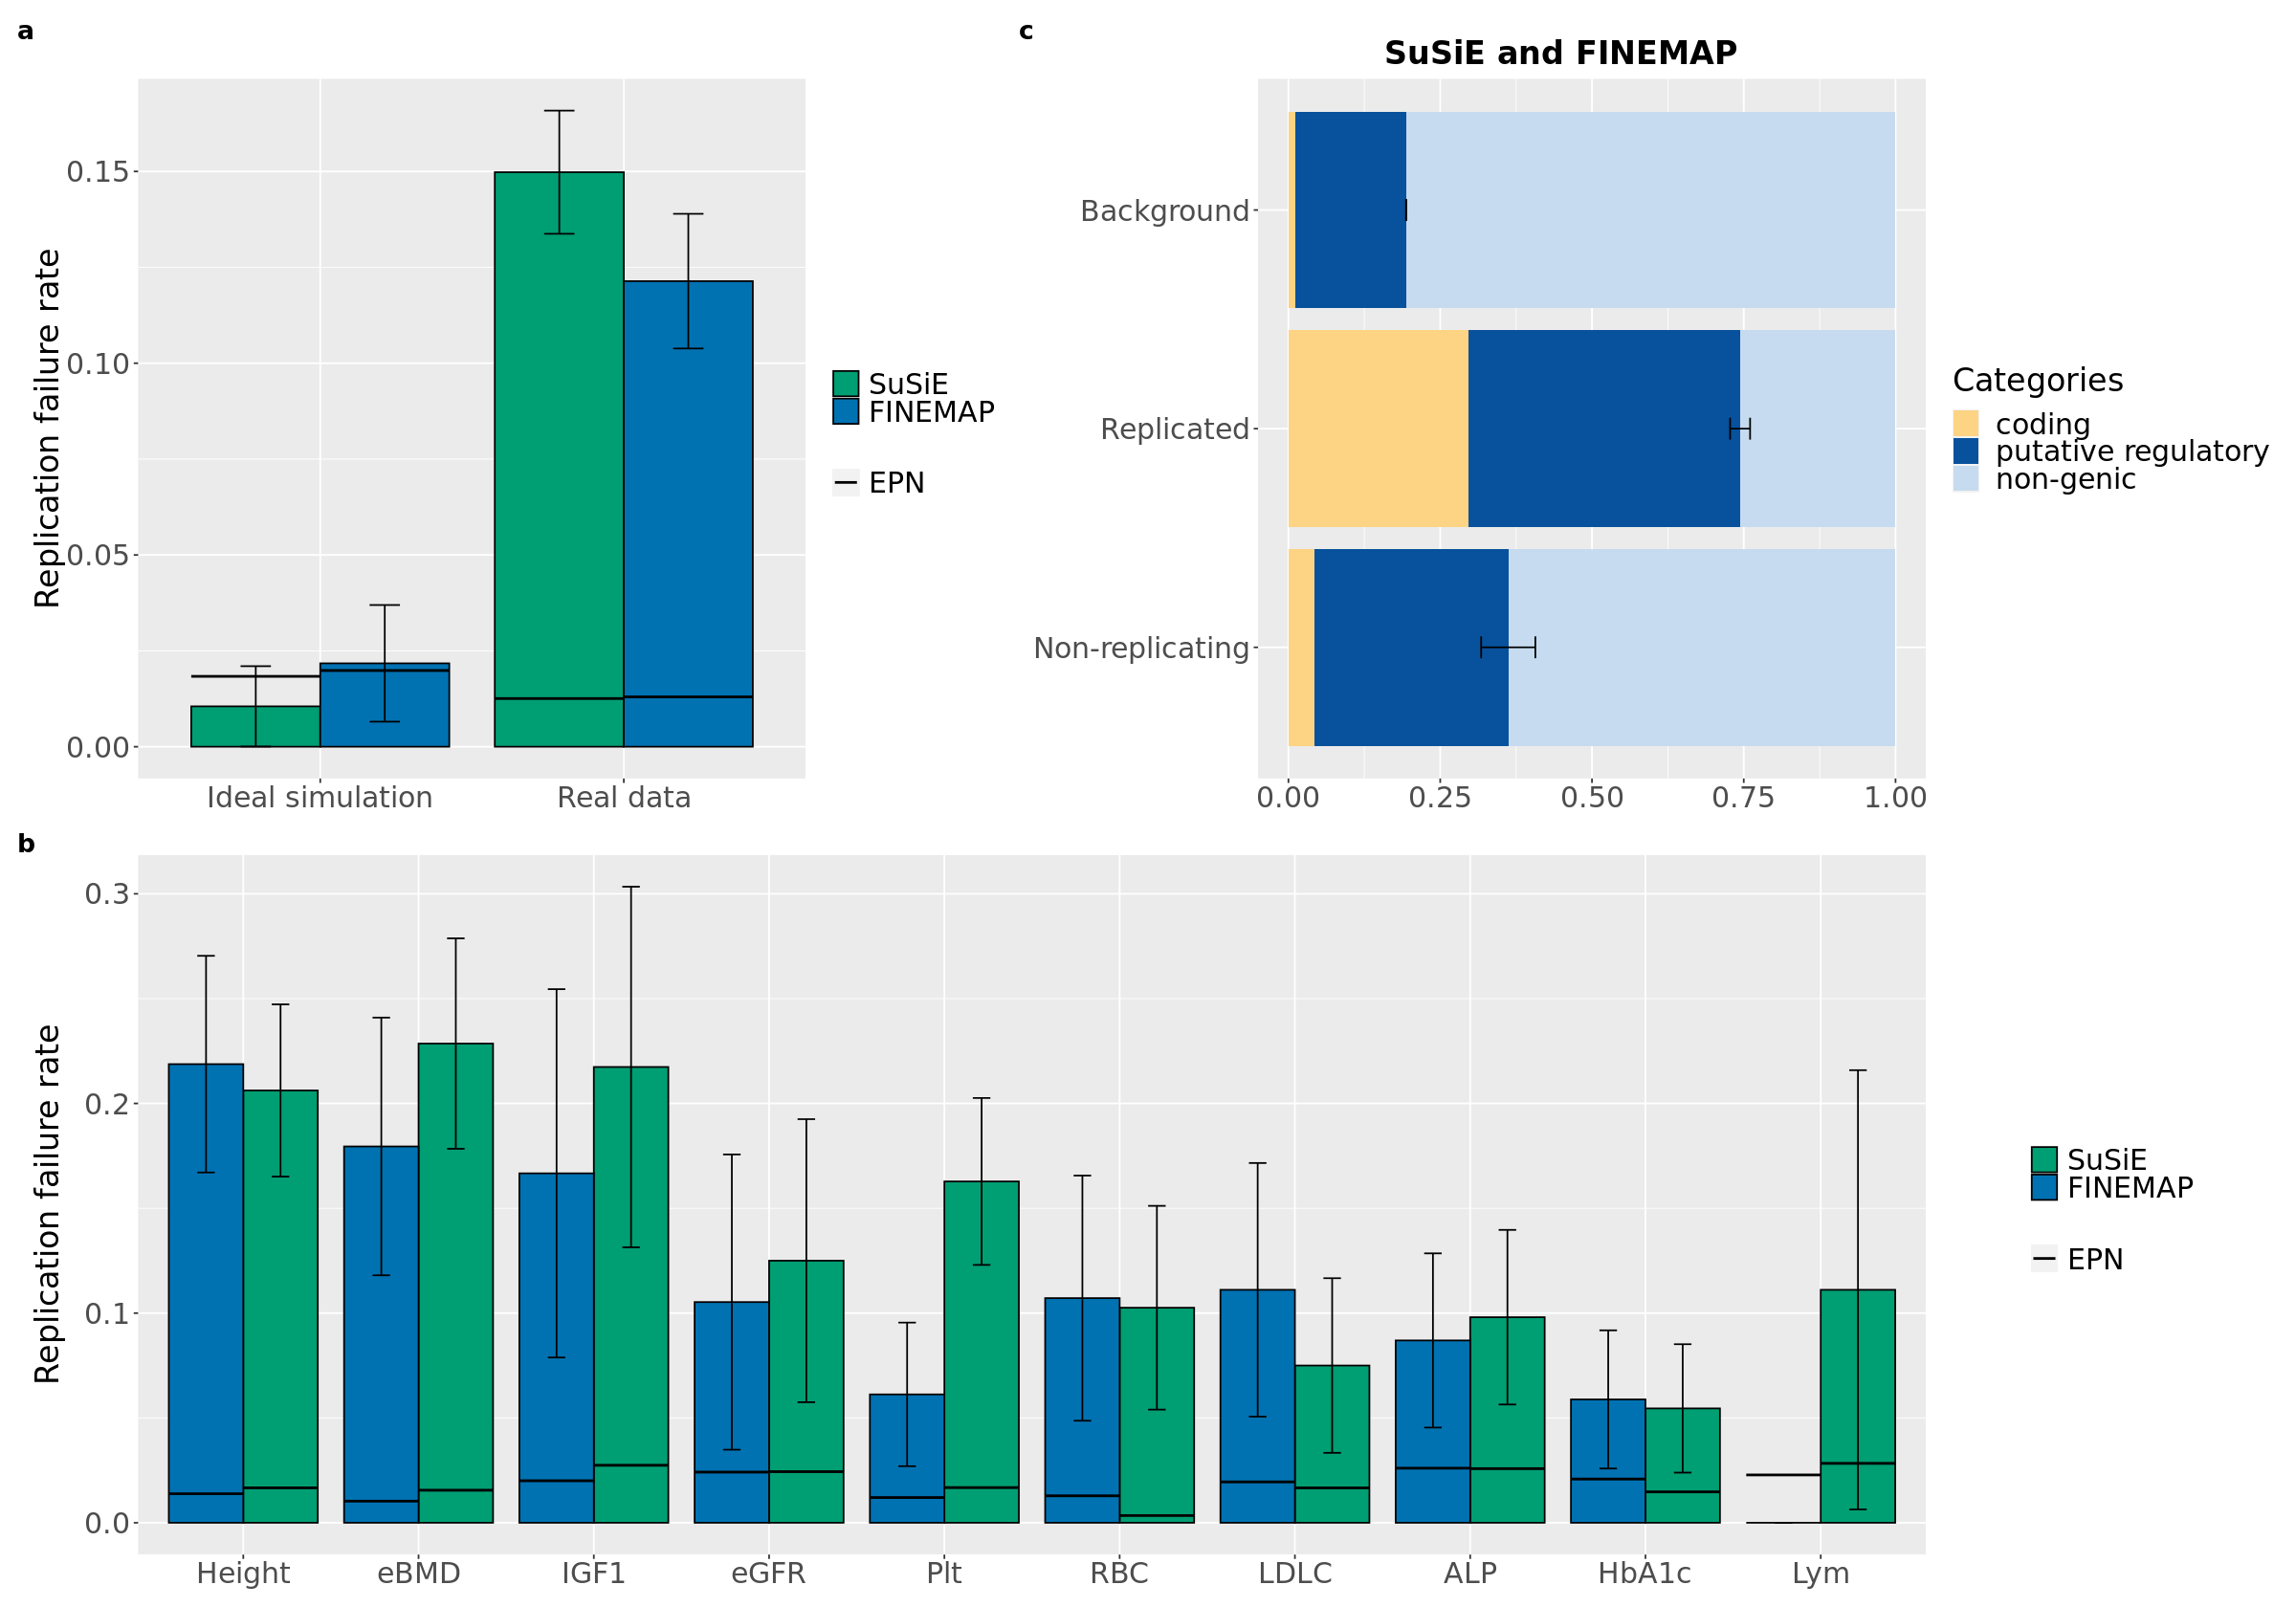

In [7]:
options(repr.plot.width=20, repr.plot.height=14)
layout <- "
AC
BB
"
fig1 <- pl_rfr + pl_trait_rfr + pl_func_enrich + plot_layout(design = layout)+
 plot_annotation(tag_levels = "a") & theme(plot.tag = element_text(face = 'bold', size=16))
fig1

# Fig 2

In [8]:
calib_df = read_excel("Supplementary Tables.xlsx", sheet = 3)
selected_sims = c('Ideal','Baseline misspecification',
                  'Moderate non-sparsity','High non-sparsity','Very high non-sparsity','No large effects')
selected_methods = c('SuSiE','SuSiE-inf','FINEMAP','FINEMAP-inf','minPIP','minPIP-inf')
calib_to_plot <- calib_df %>% filter(sim_name %in% selected_sims)
calib_to_plot$sim_name = factor(calib_to_plot$sim_name, selected_sims)
calib_to_plot$method_name = factor(calib_to_plot$method_name, selected_methods)
calib_to_plot[,c('mean','lower','upper')] = binom.confint(calib_to_plot$num_causal,calib_to_plot$num_snps, 
                                                   conf.level=0.95, methods='exact')[,c('mean','lower','upper')]
calib_to_plot$bin_name <- factor(calib_to_plot$bin_name, 
                                 levels=c('[0,0.01]','(0.1,0.5]','(0.5,0.9]','(0.9,1]'))
pl_calib <- ggplot(calib_to_plot, aes(bin_name, prop_causal)) +
    geom_pointrange(
        aes(ymin = lower, ymax = upper, color = sim_name, shape=method_name,
            group=interaction(method_category, sim_name)),
        position = position_dodge(1),
        size=1.1)+
    geom_hpline(aes(bin_name, mean_pip, color= sim_name, linetype=EPC,
                    group=interaction(method_category, sim_name)), 
                position=position_dodge(1), size = 1, 
                width = 0.08,inherit.aes = FALSE, color='black')+
    ylab('Proportion causal')+
    xlab("PIP bins") + pl_theme + theme(strip.background = element_blank(),
                                        strip.text.y = element_blank())+
    scale_shape_manual(values=method_shapes) +
    scale_color_manual(values=sim_colors[selected_sims]) +
    guides(color=guide_legend(title="Simulation type"),
           shape=guide_legend(title="Method"),
           group=guide_legend(title=" ")) 

New names:
• `` -> `...1`


In [9]:
recall_df = read_excel("Supplementary Tables.xlsx", sheet = 4)
recall_to_plot <- recall_df %>% filter(sim_name %in% selected_sims) 
recall_to_plot$sim_name = factor(recall_to_plot$sim_name, selected_sims)
recall_to_plot$method_name = factor(recall_to_plot$method_name, selected_methods)
recall_to_plot[,c('mean','lower','upper')] = binom.confint(recall_to_plot$n_true_pos,recall_to_plot$tot_causal, 
                                                   conf.level=0.95, methods='exact')[,c('mean','lower','upper')]
pl_recall <- ggplot(recall_to_plot, aes(factor(top_n), recall)) +
    geom_pointrange(
        aes(ymin = lower, ymax = upper, color = sim_name, shape=method_name,
            group=interaction(method_category, sim_name)),
        position = position_dodge(1),
        size=1.1)+
    ylab('Recall')+
    xlab("Top N variants") + pl_theme + theme(legend.position='none',
                                        strip.background = element_blank(),
                                        strip.text.y = element_blank())+
    scale_shape_manual(values=method_shapes) +
    scale_color_manual(values=sim_colors) 

New names:
• `` -> `...1`


In [10]:
regression_df = read_excel("Supplementary Tables.xlsx", sheet = 5)
regression_df$component_name = factor(regression_df$component_name,
                                      levels = c("Large sparse effects",
                                                 "Non-missing\nnon-sparse effects",
                                                 "Missing\nnon-sparse effects",
                                                 "Stratification effect"))
pl_regression <- ggplot(regression_df, aes(x=1, y=fstats)) +
    facet_wrap(.~component_name, scales="free",nrow=1) +
    geom_violin(aes(fill=causal_status)) +
    ylab('Regression F statistics') +
    pl_theme +
    theme(axis.title.x = element_blank(),
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank()) +
    guides(fill=guide_legend(title="Causal status")) 

New names:
• `` -> `...1`


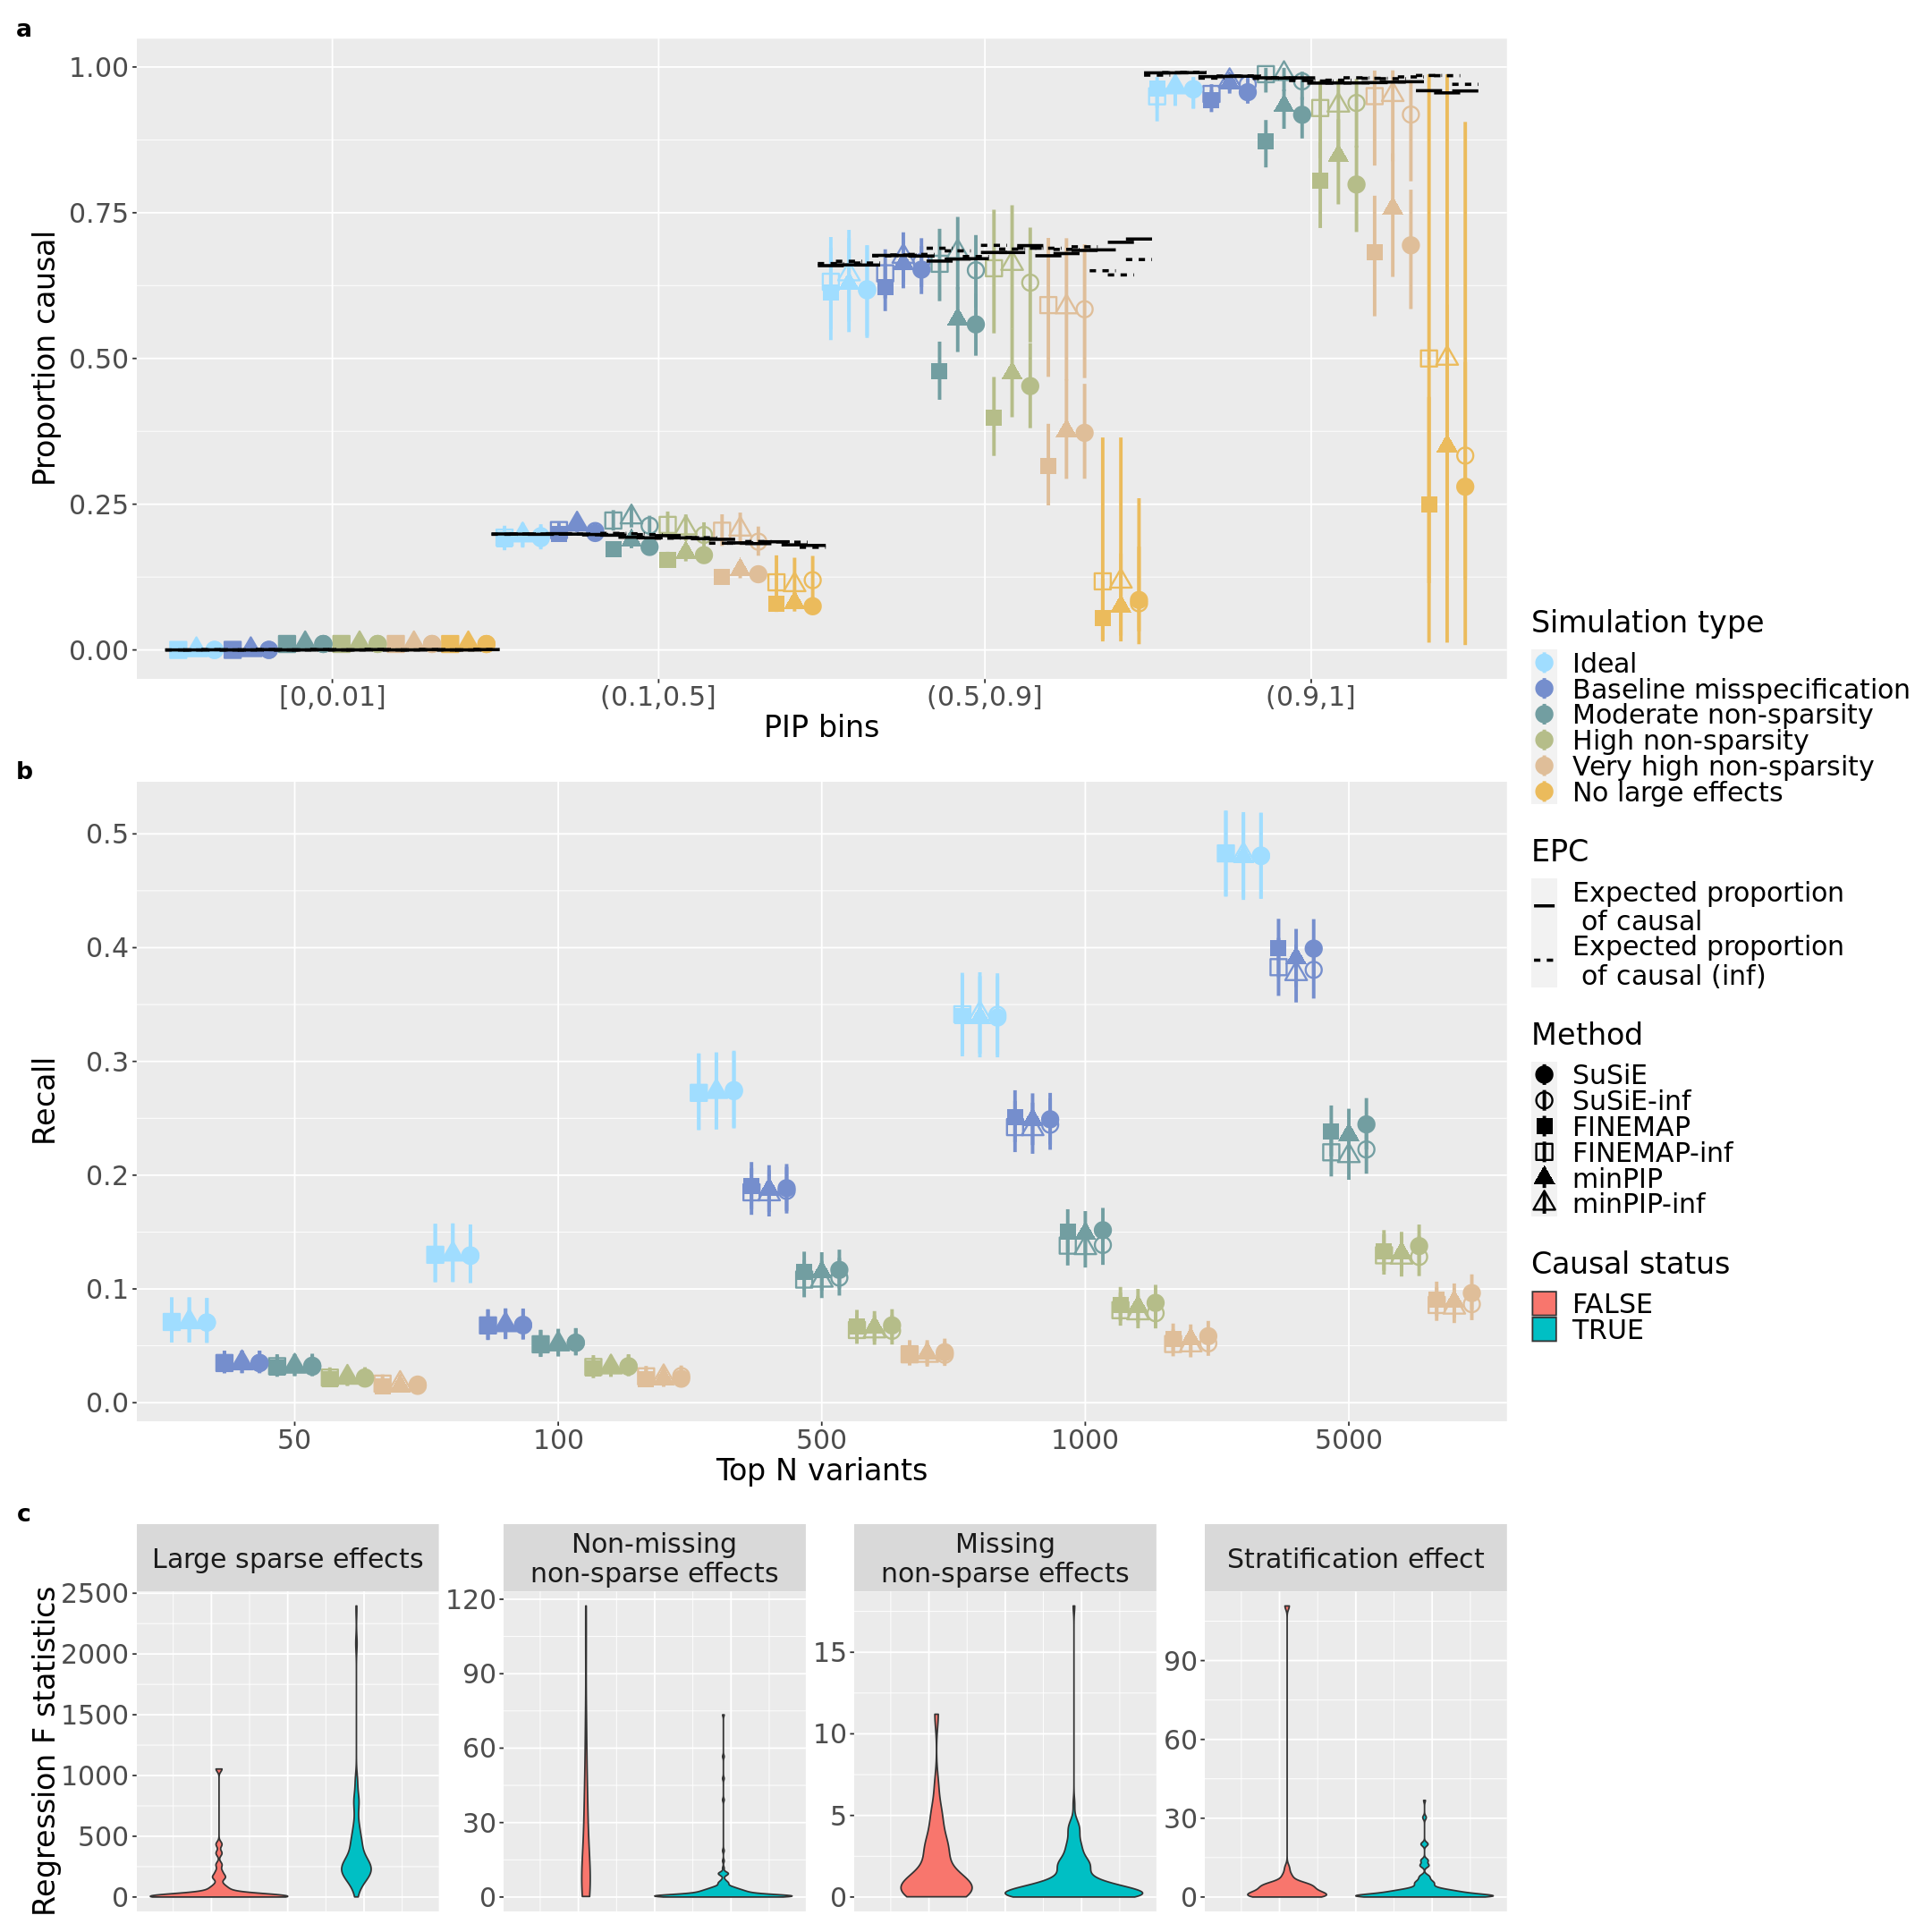

In [11]:
options(repr.plot.width=18, repr.plot.height=18)
layout <- "
A
A
B
B
C
"
fig2 <- pl_calib + pl_recall + pl_regression +plot_layout(design=layout,guides='collect')+
 plot_annotation(tag_levels = "a") & theme(plot.tag = element_text(face = 'bold', size=16))
fig2

# Fig. 3

In [12]:
selected_sims = c('Moderate stratification w/ BOLT',
                  'Severe stratification w/ BOLT',
                  'Moderate stratification w/ OLS',
                  'Severe stratification w/ OLS')
calib_to_plot <- calib_df %>% filter(sim_name %in% selected_sims)
calib_to_plot$sim_name = factor(calib_to_plot$sim_name, selected_sims)
calib_to_plot$method_name = factor(calib_to_plot$method_name, selected_methods)
calib_to_plot[,c('mean','lower','upper')] = binom.confint(calib_to_plot$num_causal,calib_to_plot$num_snps, 
                                                   conf.level=0.95, methods='exact')[,c('mean','lower','upper')]
calib_to_plot$bin_name <- factor(calib_to_plot$bin_name, 
                                 levels=c('[0,0.01]','(0.1,0.5]','(0.5,0.9]','(0.9,1]'))
pl_calib <- ggplot(calib_to_plot, aes(bin_name, prop_causal)) +
    geom_pointrange(
        aes(ymin = lower, ymax = upper, color = sim_name, shape=method_name,
            group=interaction(method_category, sim_name)),
        position = position_dodge(1),
        size=1.1)+
    geom_hpline(aes(bin_name, mean_pip, color= sim_name, linetype=EPC,
                    group=interaction(method_category, sim_name)), 
                position=position_dodge(1), size = 1, 
                width = 0.08,inherit.aes = FALSE, color='black')+
    ylab('Proportion causal')+
    xlab("PIP bins") + pl_theme + theme(strip.background = element_blank(),
                                        strip.text.y = element_blank())+
    scale_shape_manual(values=method_shapes) +
    scale_color_manual(values=sim_colors[selected_sims]) +
    guides(color=guide_legend(title="Simulation type"),
           shape=guide_legend(title="Method"),
           group=guide_legend(title=" ")) 

In [13]:
recall_to_plot <- recall_df %>% filter(sim_name %in% selected_sims) 
recall_to_plot$sim_name = factor(recall_to_plot$sim_name, selected_sims)
recall_to_plot$method_name = factor(recall_to_plot$method_name, selected_methods)
recall_to_plot[,c('mean','lower','upper')] = binom.confint(recall_to_plot$n_true_pos,recall_to_plot$tot_causal, 
                                                   conf.level=0.95, methods='exact')[,c('mean','lower','upper')]
pl_recall <- ggplot(recall_to_plot, aes(factor(top_n), recall)) +
    geom_pointrange(
        aes(ymin = lower, ymax = upper, color = sim_name, shape=method_name,
            group=interaction(method_category, sim_name)),
        position = position_dodge(1),
        size=1.1)+
    ylab('Recall')+
    xlab("Top N variants") + pl_theme + theme(legend.position='none',
                                        strip.background = element_blank(),
                                        strip.text.y = element_blank())+
    scale_shape_manual(values=method_shapes) +
    scale_color_manual(values=sim_colors) 

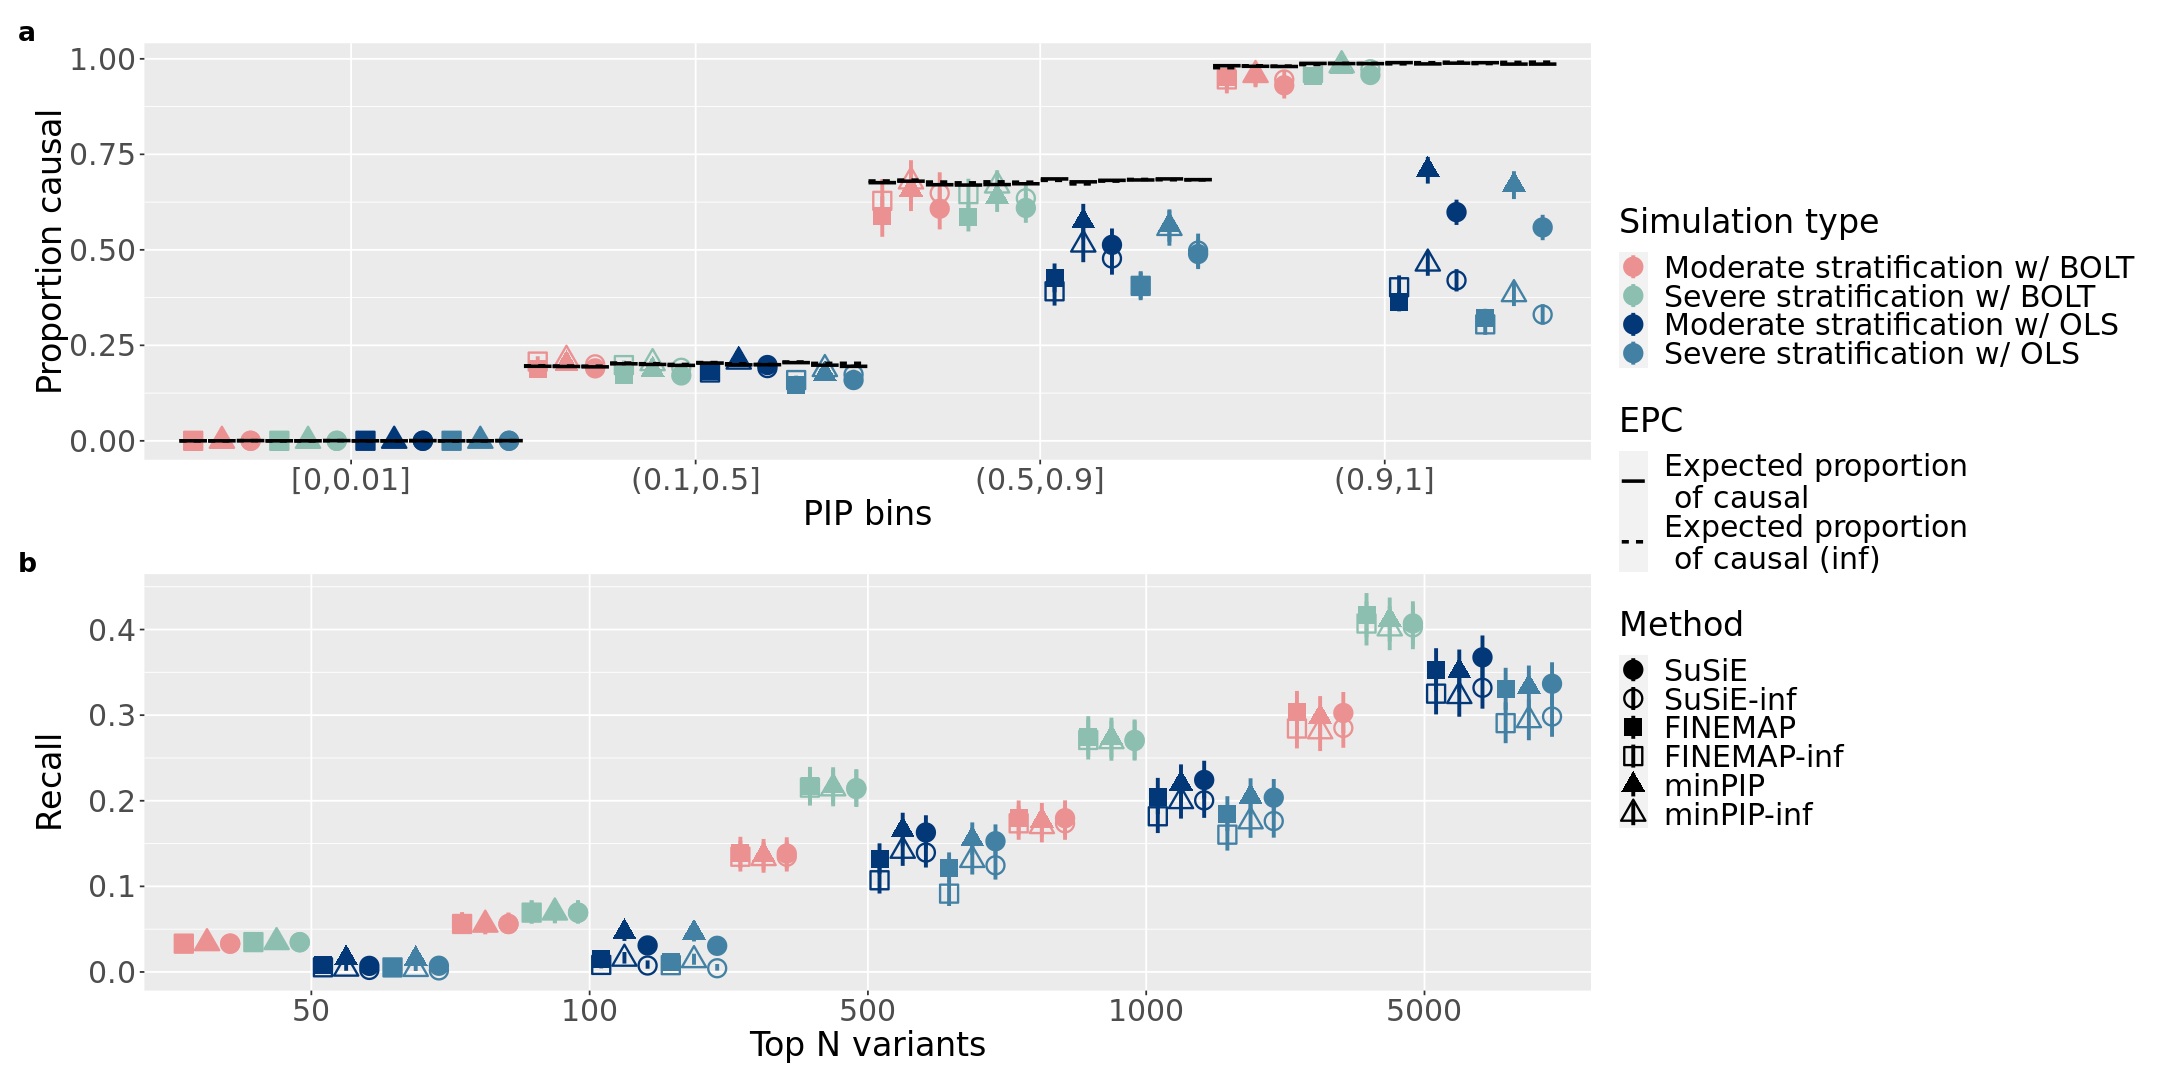

In [14]:
options(repr.plot.width=18, repr.plot.height=9)
layout <- "
A
B
"
fig3 <- pl_calib + pl_recall +plot_layout(design=layout,guides='collect')+
 plot_annotation(tag_levels = "a") & theme(plot.tag = element_text(face = 'bold', size=16))
fig3

# Fig. 4

In [15]:
# Aggregated RFR plot
rfr_df = read_excel("Supplementary Tables.xlsx", sheet = 1)
all_rfr = rfr_df %>% dplyr::select('trait','method_name','n_highpip','rfr','epn','data.type') %>%
    filter(data.type=='Real data')
all_rfr$segment_legend='EPN'
# Compute Binomial proportion SD
all_rfr$std = sqrt((all_rfr$rfr)*(all_rfr$n_highpip)*(1-all_rfr$rfr))/all_rfr$n_highpip
# Filter to aggregated RFR
selected_method_names = c('SuSiE','FINEMAP','SuSiE-inf','FINEMAP-inf')
data_to_plot = all_rfr %>% filter(trait=='agg') %>% filter(method_name %in% selected_method_names)
data_to_plot$method_name <- factor(data_to_plot$method_name, levels = selected_method_names)
# Compute EPN line segment positions
num_methods = length(selected_method_names)
barwidth = 0.85
pos_dodge = 1
xstart = seq(1-barwidth/2,num_methods-barwidth/2,length.out=num_methods)
xend = seq(1+barwidth/2,num_methods+barwidth/2,length.out=num_methods)
# Plot
pl_rfr = ggplot(data=data_to_plot, aes(x=method_name, y=rfr, fill=method_name)) +
    geom_bar(position=position_dodge(), color='black', stat="identity",width=0.85) + 
    geom_segment(data=data_to_plot, aes(x=xstart, y=epn, 
                 xend=xend, yend=epn, 
                 color=method_name,linetype=`segment_legend`), 
                 size=1,color='black',inherit.aes = FALSE)+
    geom_errorbar(aes(ymin=rfr-std, ymax=rfr+std),position=position_dodge(.85),width=0.2)+
    ylab(label = "Replication failure rate")+
    scale_linetype_manual("EPN",values=c("EPN"=1.5))+
    scale_fill_manual(values=method_colors[selected_method_names])+
    pl_theme + theme(axis.title.x = element_blank(),
                     legend.title = element_blank(),
                     axis.text.x = element_blank(),
                     axis.ticks.x = element_blank())

New names:
• `` -> `...1`


In [16]:
set_diff_enrich = read_excel("Supplementary Tables.xlsx", sheet = 6)
selected = c('High-PIP for SuSiE \n and not SuSiE-inf',
                              'High-PIP for SuSiE-inf \n and not SuSiE',
                              'High-PIP for FINEMAP \n and not FINEMAP-inf',
                              'High-PIP for FINEMAP-inf \n and not FINEMAP')
set_diff_enrich = set_diff_enrich %>% filter(type_name %in% selected)
set_diff_enrich$type_name <-factor(set_diff_enrich$type_name, levels= selected)
melted_data <-  reshape2::melt(set_diff_enrich, id.vars = c("type_name"), measure.vars = simple_annot_names)
data <- group_by(melted_data,type_name)
data <- mutate(data, prop = value / sum(value), 
               std = sqrt(sum(value)*(value/sum(value))*(1-(value/sum(value))))/sum(value),
               sd_pos = cumsum(prop))
data$type_name<-factor(data$type_name, levels= selected)
data$variable <- factor(data$variable,levels=simple_annot_names)

pl_set_diff_enrich <- qplot(x = type_name, y = prop, fill = variable, data = data, geom = "col") +
    geom_errorbar(aes(x=type_name,ymin=1-prop+std,ymax=1-prop-std),width=.1, 
                  data=data %>% filter(variable=='non-genic'),
                  inherit.aes = FALSE)+
    ggtitle('High-PIP set difference functional enrichment')+
    pl_theme + theme(plot.title = element_text(hjust=0.4),
                         axis.title=element_blank(), legend.title= element_blank()) +
    scale_fill_manual(values = simple_annot_colors) + coord_flip()

New names:
• `` -> `...1`


In [17]:
prs_df = read_excel("Supplementary Tables.xlsx", sheet = 7)
point_size = 6
#SuSiE and SuSiE-inf
df.melt = (prs_df %>% 
           filter(method_name %in% c('SuSiE','SuSiE-inf')) %>% 
           select(trait,method_name,delta_r2,cohort))
plot_df = dcast(setDT(df.melt), trait+cohort ~ method_name, value.var = "delta_r2")
p1 = ggplot(plot_df,
       aes(x=SuSiE,y=`SuSiE-inf`, color=trait, shape=cohort)) +
    geom_point(size=point_size)+
    geom_abline(slope=1)+
    xlim(-0.001,NA)+ylim(-0.001,NA)+
    xlab('SuSiE delta R2')+ylab('SuSiE-inf delta R2')+
    scale_color_manual(values=pheno_colors[unique(plot_df$trait)])+
    pl_theme
# FINEMAP and FINEMAPinf
df.melt = (prs_df %>% 
           filter(method_name %in% c('FINEMAP','FINEMAP-inf')) %>% 
           select(trait,method_name,delta_r2,cohort))
plot_df = dcast(setDT(df.melt), trait+cohort ~ method_name, value.var = "delta_r2")
p2 = ggplot(plot_df,
       aes(x=FINEMAP,y=`FINEMAP-inf`, color=trait,shape=cohort)) +
    geom_point(size=point_size)+
    geom_abline(slope=1)+
    xlim(-0.001,NA)+ylim(-0.001,NA)+
    xlab('FINEMAP delta R2')+ylab('FINEMAP-inf delta R2')+
    scale_color_manual(values=pheno_colors[unique(plot_df$trait)])+
    pl_theme

pl_prs <- p1 + p2  + plot_layout(ncol = 2, guides = "collect") +
plot_annotation(
  title = "PRS delta R2 comparisons",
  theme = theme(plot.title = element_text(size = 22,face='bold',hjust=0.4))
)

New names:
• `` -> `...1`


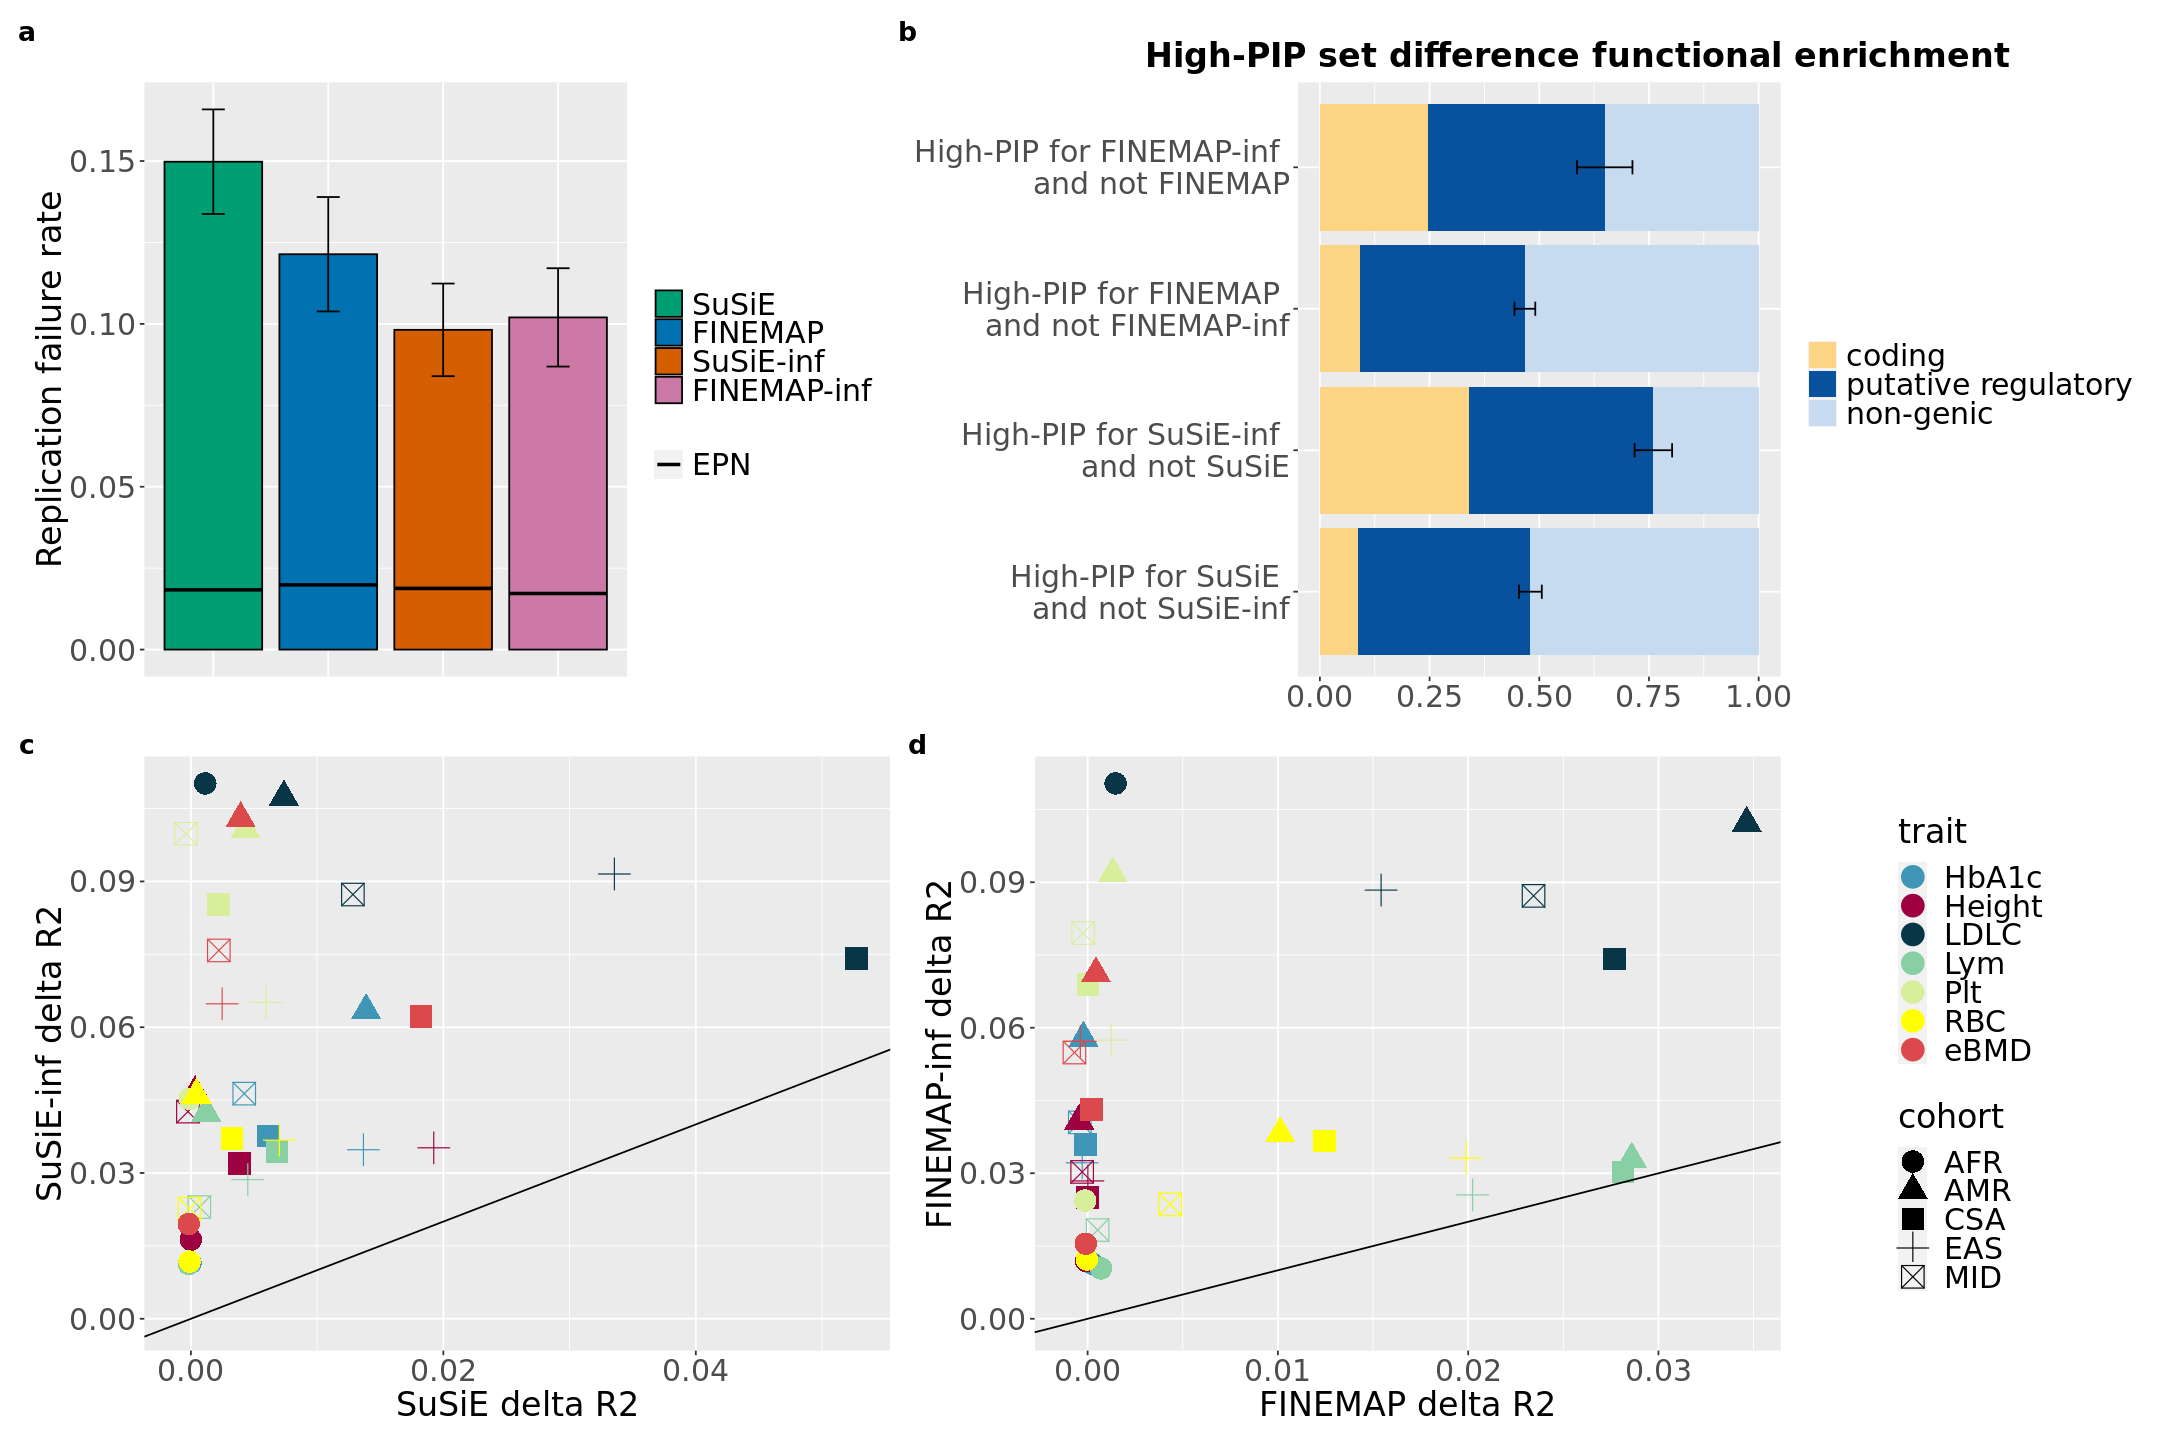

In [18]:
options(repr.plot.width=18, repr.plot.height=12)
layout <- "
AB
CC
"
fig4 <- pl_rfr + pl_set_diff_enrich + pl_prs + plot_layout(design = layout)+
 plot_annotation(tag_levels = "a") & theme(plot.tag = element_text(face = 'bold', size=16))
fig4

# Extended Data Fig. 1

In [19]:
rfr_diff_thresh = read_excel("Supplementary Tables.xlsx", sheet = 8)

rfr_diff_thresh$method_name = factor(rfr_diff_thresh$method_name, levels=c('ABF','COJO-ABF','SuSiE','FINEMAP',
                                                                     'SuSiE-inf','FINEMAP-inf'))
rfr_diff_thresh$segment_legend='EPN'
rfr_diff_thresh$std = sqrt((rfr_diff_thresh$rfr)*(rfr_diff_thresh$n_highpip)*(1-rfr_diff_thresh$rfr))/rfr_diff_thresh$n_highpip
selected_thresh = c(0.9,0.93,0.95,0.99)
rfr_diff_thresh <- rfr_diff_thresh %>% filter(threshold %in% selected_thresh) %>%
    filter(trait=='agg')
rfr_diff_thresh$threshold = as.factor(rfr_diff_thresh$threshold)

pos_dodge = 1
num_methods = length(unique(rfr_diff_thresh$method_name))
barwidth = 0.85/num_methods

xstart = seq(1-barwidth*num_methods/2,1+barwidth*num_methods/2-barwidth,length.out=num_methods)
xend = seq(1-barwidth*num_methods/2+barwidth,1+barwidth*num_methods/2,length.out=num_methods)
for (i in 1:3){
    new_vec = seq(1-barwidth*num_methods/2+ i*pos_dodge, 
                  1+barwidth*num_methods/2-barwidth+ i*pos_dodge, 
                  length.out=num_methods)
    xstart <- c(xstart, new_vec)
    new_vec = seq(1-barwidth*num_methods/2+barwidth+i*pos_dodge,
                  1+barwidth*num_methods/2+i*pos_dodge,
                  length.out=num_methods)
    xend <- c(xend, new_vec)
}

pl_rfr_diff_thresh = ggplot(data=rfr_diff_thresh, 
       aes(x=threshold, y=rfr, fill=method_name)) +
    geom_bar(position=position_dodge(), color='black', stat="identity",width=0.85) + 
    geom_segment(data=rfr_diff_thresh %>% filter(data_type=='Real data'), aes(x=xstart, y=epn, 
                 xend=xend, yend=epn, 
                 color=method_name,linetype=`segment_legend`), 
                 size=1,color='black',inherit.aes = FALSE)+
    geom_segment(data=rfr_diff_thresh %>% filter(data_type=='Ideal simulation'), aes(x=xstart, y=epn, 
                 xend=xend, yend=epn, 
                 color=method_name,linetype=`segment_legend`), 
                 size=1,color='black',inherit.aes = FALSE)+
    geom_errorbar(aes(ymin=rfr-std, ymax=rfr+std),position=position_dodge(.85),width=0.2)+
    facet_wrap(~data_type)+
    ylab(label = "Replication failure rate")+
    xlab(label = 'PIP threshold')+
    scale_linetype_manual("EPN",values=c("EPN"=1.5))+
    scale_fill_manual(values=method_colors[unique(rfr_diff_thresh$method_name)])+
    pl_theme + theme(legend.title = element_blank())


New names:
• `` -> `...1`


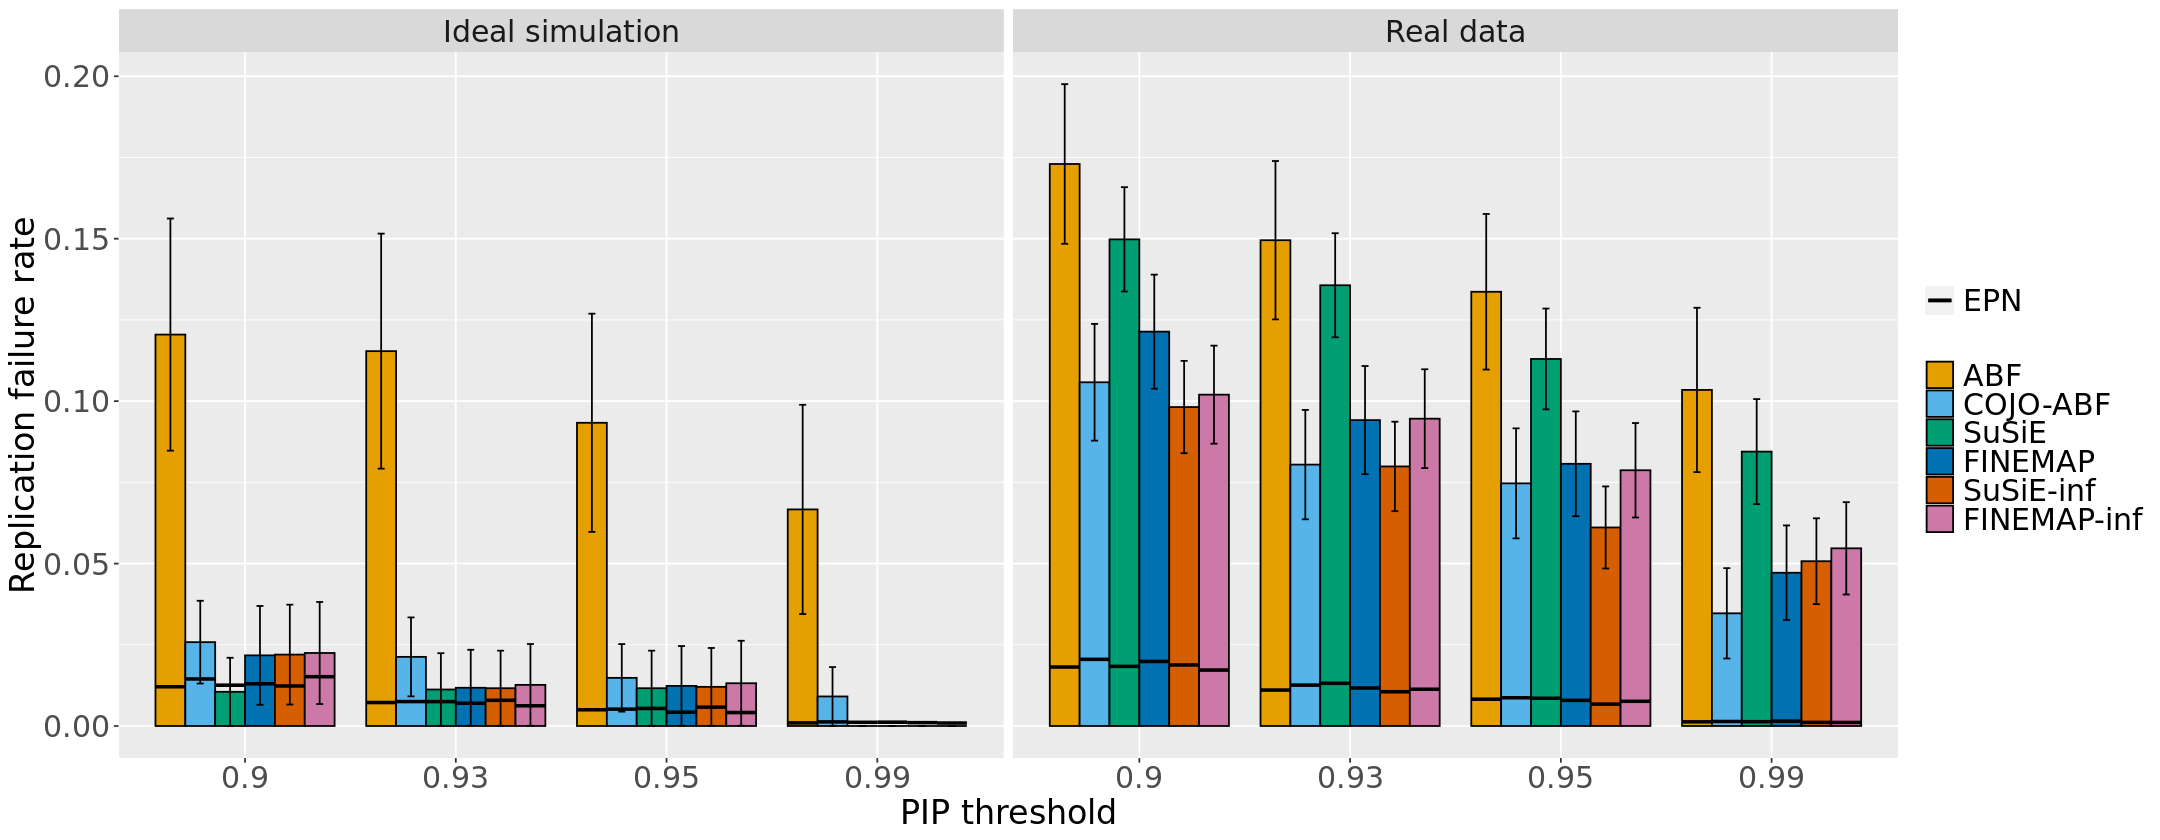

In [20]:
options(repr.plot.width=18, repr.plot.height=7)
pl_rfr_diff_thresh

# Extended Fig. 2

In [21]:
runtime.df = read_excel("Supplementary Tables.xlsx", sheet = 9)
# Distribution of region size in terms of number of SNPs
num_snps_pl = ggplot(runtime.df, aes(x=num_snps)) + 
 geom_histogram(aes(y=..density..), colour="black", fill="white")+
 geom_density(alpha=.2, fill="#FF6666") +
 xlab('Number of SNPs') +
 pl_theme
# Runtime
num_snp_quantiles = quantile(runtime.df$num_snps, probs = seq(0, 1, 0.1))
plot.df = na.omit(reshape2::melt(runtime.df %>% select(num_snps, susie_time, 
                                     susieinf_time, susieinf_with_eigdecomp_time,
                                     finemap_time, finemapinf_time, 
                                     finemapinf_with_eigdecomp_time), id = 'num_snps'))
plot.df$interval = cut(plot.df$num_snps, num_snp_quantiles, ordered_result=TRUE)
plt.df = na.omit(plot.df %>% 
                 group_by(variable,interval) %>% 
                 summarise(median=median(value,na.rm=TRUE),
                           mean = mean(value,na.rm=TRUE),
                           mean_num_snps = as.integer(mean(num_snps,na.rm=TRUE))) %>%
                 mutate(type = ifelse(grepl('eigdecomp',variable),
                                      'Eigen-decomposition\n not provided', 
                                      'Eigen-decomposition\n provided'),
                        name = ifelse(grepl('susieinf',variable),'SuSiE-inf',
                                      ifelse(grepl('susie',variable),'SuSiE',
                                             ifelse(grepl('finemapinf',variable),'FINEMAP-inf','FINEMAP')))))
options(repr.plot.width=11, repr.plot.height=5)
runtime_pl = ggplot(plt.df, aes(x=mean_num_snps, y=mean, color=name, color=type)) +
  geom_line(aes(linetype=type), size=1.5)+
  geom_point(aes(color=name), size=3) +
  scale_linetype_manual(values=c("dashed", "solid")) +
  ylab('Runtime in seconds') +
  xlab('Number of SNPs in region') +
  pl_theme + theme(legend.title=element_blank(), legend.key.size = unit(2, 'cm'))

New names:
• `` -> `...1`
`summarise()` has grouped output by 'variable'. You can override using the
`.groups` argument.
Warning message:
“Duplicated aesthetics after name standardisation: colour”


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



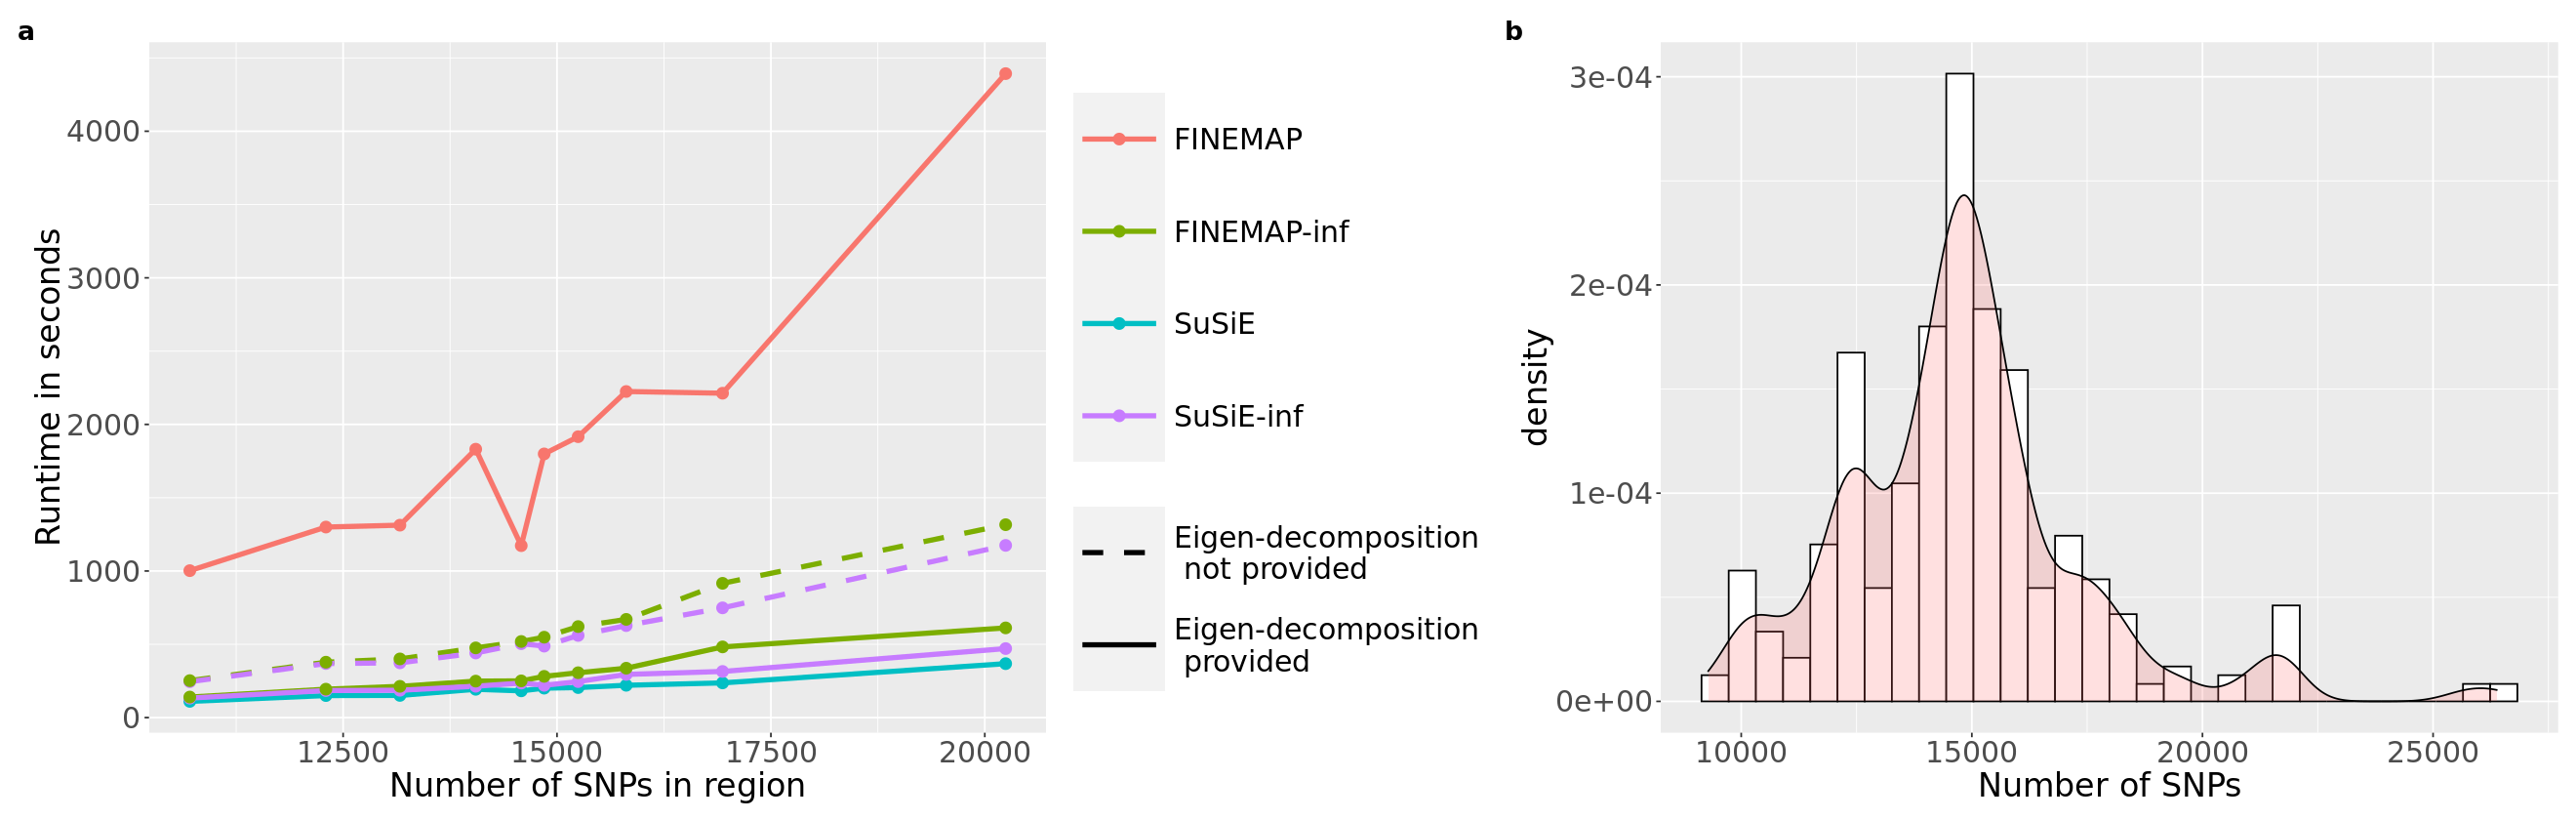

In [22]:
options(repr.plot.width=22, repr.plot.height=7)
layout <- "
AB
"
supp_fig2 <- runtime_pl + num_snps_pl + plot_layout(design = layout)+
 plot_annotation(tag_levels = "a") & theme(plot.tag = element_text(face = 'bold', size=16))
supp_fig2

# Extended Data Fig. 3

In [23]:
cs_size_df = read_excel("Supplementary Tables.xlsx", sheet = 10)
pl_cs_size <- ggplot(cs_size_df, aes(x=method, y=num_snps_in_cs, fill=method)) + 
  geom_boxplot()+
  scale_fill_manual(values=method_colors[c('SuSiE','SuSiE-inf')])+
  scale_y_break(c(40,300),scales = 0.5)+
  ylab('Credible set size') +
  pl_theme + theme(axis.title.x = element_blank(),
                   legend.position='none')

New names:
• `` -> `...1`


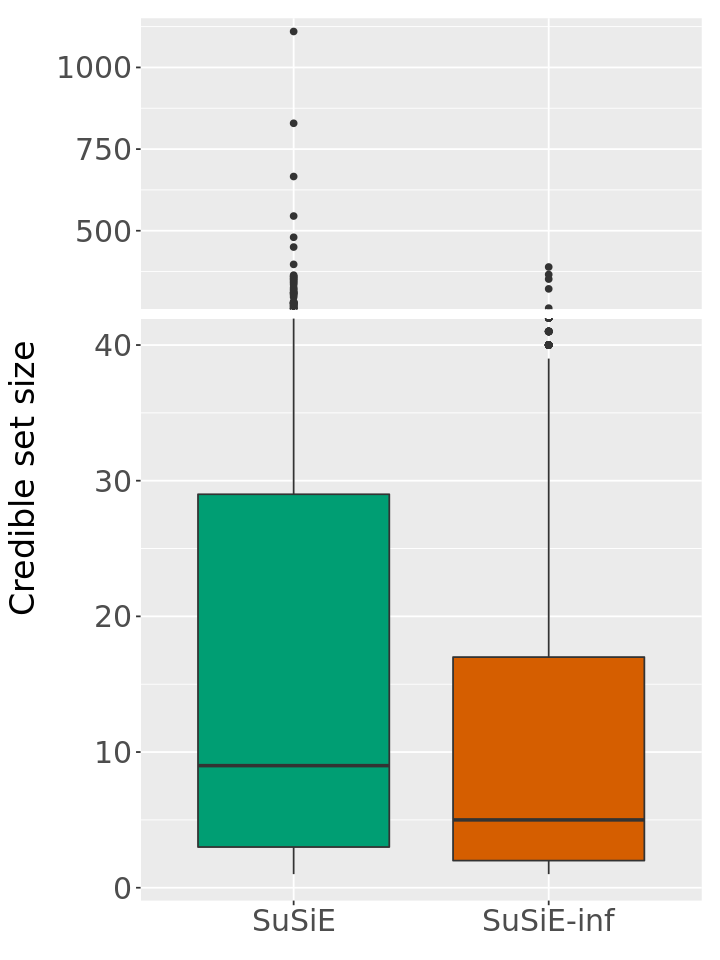

In [24]:
options(repr.plot.width=6, repr.plot.height=8)
pl_cs_size

# Extended Data Fig. 4

In [25]:
df = read_excel("Supplementary Tables.xlsx", sheet = 11)
df$Type = c('a','a','b','b','c','d')
data = df %>% 
   group_by(Type) %>% 
   summarise_at(c('num_highpip_366k','num_highpip_100k','num_rep'), sum) %>% 
   mutate(method_name = c('SuSiE&FINEMAP','SuSiE-inf&FINEMAP-inf','minPIP','minPIP-inf')) %>%
   select(c('num_highpip_366k','num_highpip_100k','num_rep','method_name')) %>%
   rename(num_highpip_366k_either = num_highpip_366k,
          num_highpip_100k_either = num_highpip_100k)

data_part_1 = data %>% filter(method_name %in% c('SuSiE&FINEMAP','SuSiE-inf&FINEMAP-inf'))
data_part_2 = data %>% filter(method_name %in% c('minPIP','minPIP-inf'))
data_to_plot = data_part_1 %>% mutate(num_highpip_366k_both = data_part_2$num_highpip_366k_either,
                       num_highpip_100k_both = data_part_2$num_highpip_100k_either) %>%
                        select(num_highpip_366k_either, num_highpip_100k_either, num_rep,
                               num_highpip_366k_both, num_highpip_100k_both)

data_to_plot <- data_to_plot[2, -1] / data_to_plot[1, -1]
data_to_plot$id = 'A'
selected = c('num_highpip_100k_either','num_rep','num_highpip_100k_both')
data_to_plot <- data_to_plot %>% reshape2::melt(id.vars='id') %>% 
    filter(variable %in% selected)
data_to_plot$variable = factor(data_to_plot$variable, levels=selected)

data_to_plot$reduction = 1-data_to_plot$value

pl_reduction <- ggplot(data=data_to_plot, 
       aes(x=variable, y=reduction, fill=variable)) +
    geom_bar(color='black', stat="identity",width=0.85, show.legend = FALSE) +
    ylab('Proportion of reduction') +
    pl_theme +
    theme(axis.title.x = element_blank()) +
    scale_x_discrete(labels=c("num_highpip_100k_either"="High-PIP",
                              "num_rep" = "Replicated",
                              "num_highpip_100k_both" = "Shared high-PIP"))

New names:
• `` -> `...1`


In [26]:
# Top N SNPs enrichment plot
top_n = read_excel("Supplementary Tables.xlsx", sheet = 12)
selected_methods = c('SuSiE','SuSiE-inf','FINEMAP','FINEMAP-inf') 
top_n = (top_n %>% filter(method_name %in% selected_methods) %>% mutate(coding=(LoF + missense))
                            %>% mutate('putative regulatory'=(synonymous+UTR3+UTR5+promoter+CRE+conserved))
                            %>% dplyr::select(top_N, method_name, coding, 'putative regulatory', 'non-genic'))
melted_data <-  reshape2::melt(top_n , id.vars = c("top_N","method_name"), measure.vars = simple_annot_names)
data <- melted_data %>% group_by(top_N,method_name)
data <- mutate(data, prop = value / sum(value), 
               std = sqrt(sum(value)*(value/sum(value))*(1-(value/sum(value))))/sum(value),
               sd_pos = cumsum(prop))
data$method_name<-factor(data$method_name, levels= selected_methods)
data$variable <- factor(data$variable,levels=simple_annot_names)
pl_top_n <- qplot(x = method_name, y = prop, fill = variable, data = data, geom = "col") +
geom_errorbar(aes(x=method_name,ymin=1-prop+std,ymax=1-prop-std),width=.1, 
              data=data %>% filter(variable=='non-genic'),
              inherit.aes = FALSE)+
facet_wrap(~top_N)+
ggtitle('Top N variants functional enrichment')+
scale_fill_manual(values = simple_annot_colors) +
pl_theme + coord_flip() + theme(axis.title=element_blank(),
                                legend.title=element_blank())

New names:
• `` -> `...1`


In [27]:
highpip_enrich = read_excel("Supplementary Tables.xlsx", sheet = 13)
selected = c('SuSiE','SuSiE-inf','SuSiE match inf','FINEMAP','FINEMAP-inf','FINEMAP match inf')
highpip_enrich <- (highpip_enrich %>% mutate(coding=(LoF + missense))
                            %>% mutate('putative regulatory'=(synonymous+UTR3+UTR5+promoter+CRE+conserved))
                            %>% dplyr::select(method_name, coding, 'putative regulatory', 'non-genic'))
melted_data <- reshape2::melt(highpip_enrich %>% filter(method_name %in% selected), 
                     id.vars = c("method_name"), measure.vars = simple_annot_names)
data <- group_by(melted_data,method_name)
data <- mutate(data, prop = value / sum(value), 
               std = sqrt(sum(value)*(value/sum(value))*(1-(value/sum(value))))/sum(value),
               sd_pos = cumsum(prop))
data$method_name<-factor(data$method_name, levels= selected)
data$variable <- factor(data$variable,levels=simple_annot_names)
#data <- data %>% filter(type %in% c('Background','Replicated','Non-replicating'))
pl_highpip_enrich <- qplot(x = method_name, y = prop, fill = variable, data = data, geom = "col") +
    geom_errorbar(aes(x=method_name,ymin=1-prop+std,ymax=1-prop-std),width=.1, 
                  data=data %>% filter(variable=='non-genic'),
                  inherit.aes = FALSE)+
    ggtitle('High-PIP variants functional enrichment')+
    pl_theme + theme(axis.title=element_blank(),
                     legend.title=element_blank()) +
    scale_fill_manual(values = simple_annot_colors) + coord_flip()

New names:
• `` -> `...1`


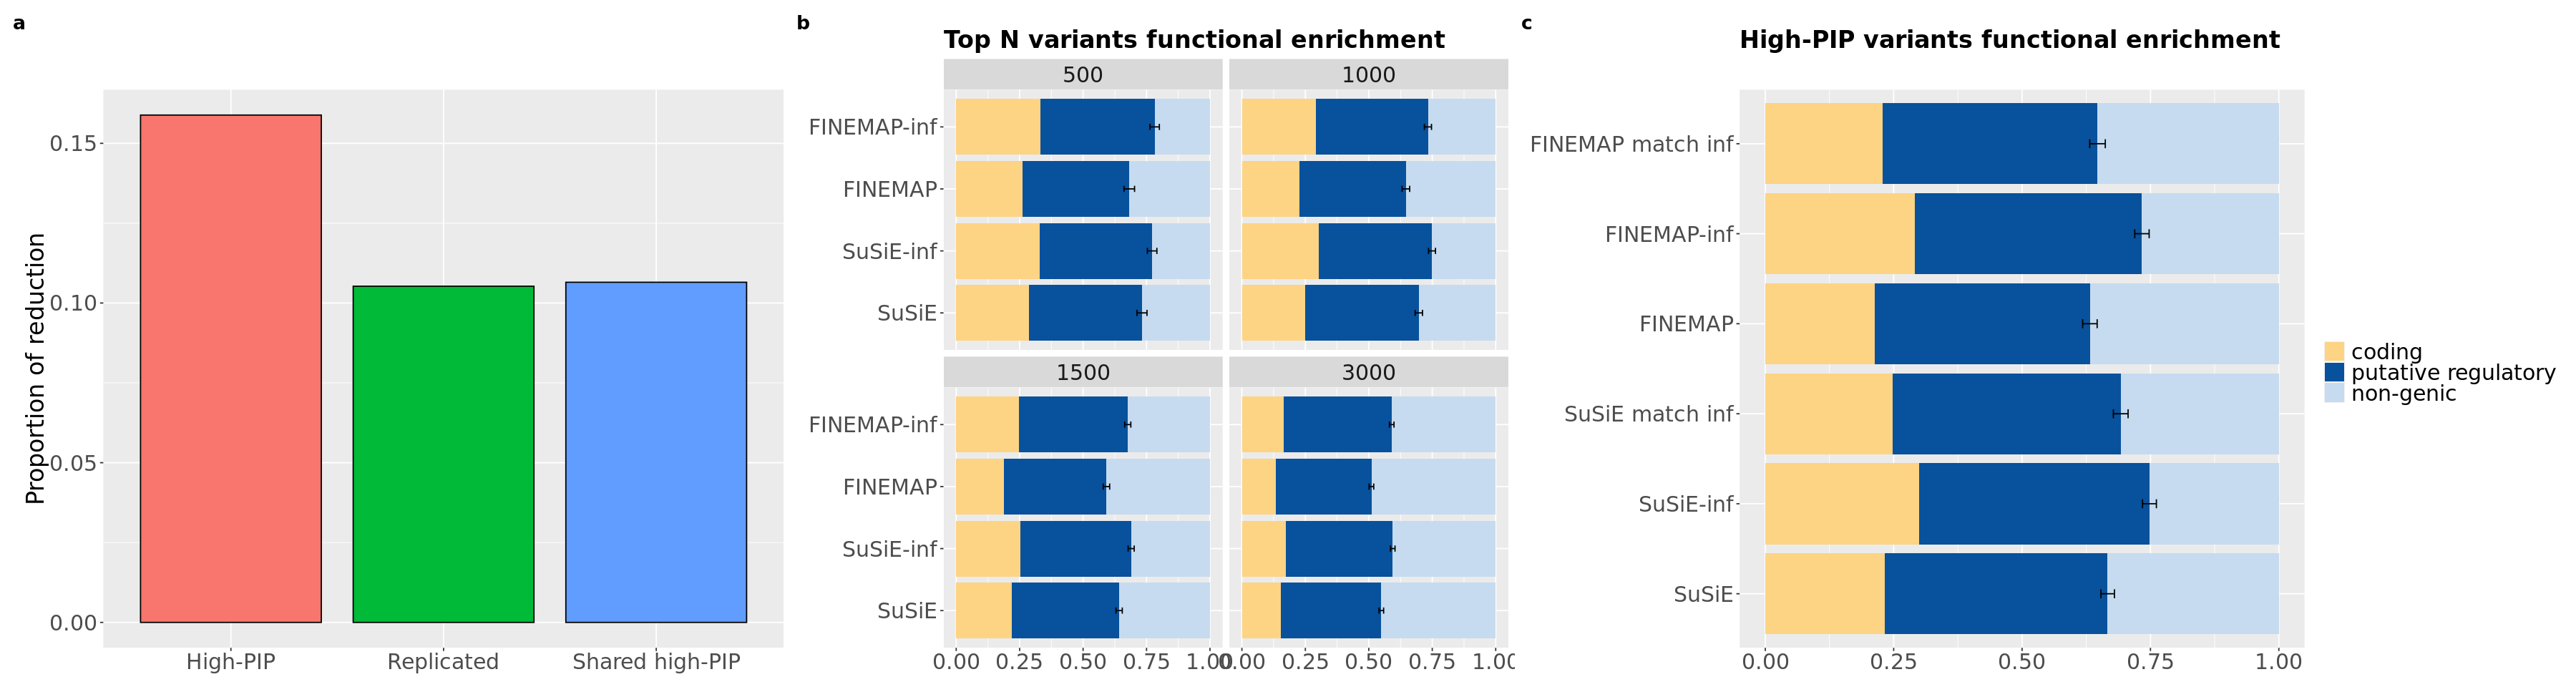

In [28]:
options(repr.plot.width=30, repr.plot.height=8)
layout <- "
ABB
"
pl_enrich =  pl_top_n + pl_highpip_enrich + plot_layout(guides='collect')
supp_fig4 <- pl_reduction +pl_enrich + plot_layout(design = layout)+
 plot_annotation(tag_levels = "a") & theme(plot.tag = element_text(face = 'bold', size=16))
supp_fig4

# Extended Fig. 5

In [29]:
tausq = read_excel("Supplementary Tables.xlsx", sheet = 14)
tausq_to_plot = tausq %>% group_by(sim_name) %>% 
    summarise(mean = mean(susie_inf_tausq), sd = sd(susie_inf_tausq)) %>%
    mutate(lower = mean-sd, upper = mean+sd)
selected_sims = c("Baseline misspecification", 
        "Moderate non-sparsity", 
        "High non-sparsity", 
        "Very high non-sparsity", 
        "No large effects")
tausq_to_plot$sim_name = factor(tausq_to_plot$sim_name, levels=selected_sims)
pl_sim_tausq = ggplot(tausq_to_plot, aes(sim_name, mean)) +
    geom_pointrange(
        aes(ymin = lower, ymax =upper, color = sim_name),
        position = position_dodge(1),
        size=1.1)+
    ylab('Estimated tau squared')+ pl_theme +
    scale_color_manual(values=sim_colors[selected_sims]) +
    scale_x_discrete(labels=c("Baseline misspecification" = "Baseline\n misspecification",
                              "Moderate non-sparsity" = "Moderate\n non-sparsity",
                              "High non-sparsity" = "High\n non-sparsity",
                              "Very high non-sparsity" = "Very high\n non-sparsity")) +
    theme(axis.title.x = element_blank(),
          legend.title = element_blank(),
          legend.position='none')

New names:
• `` -> `...1`


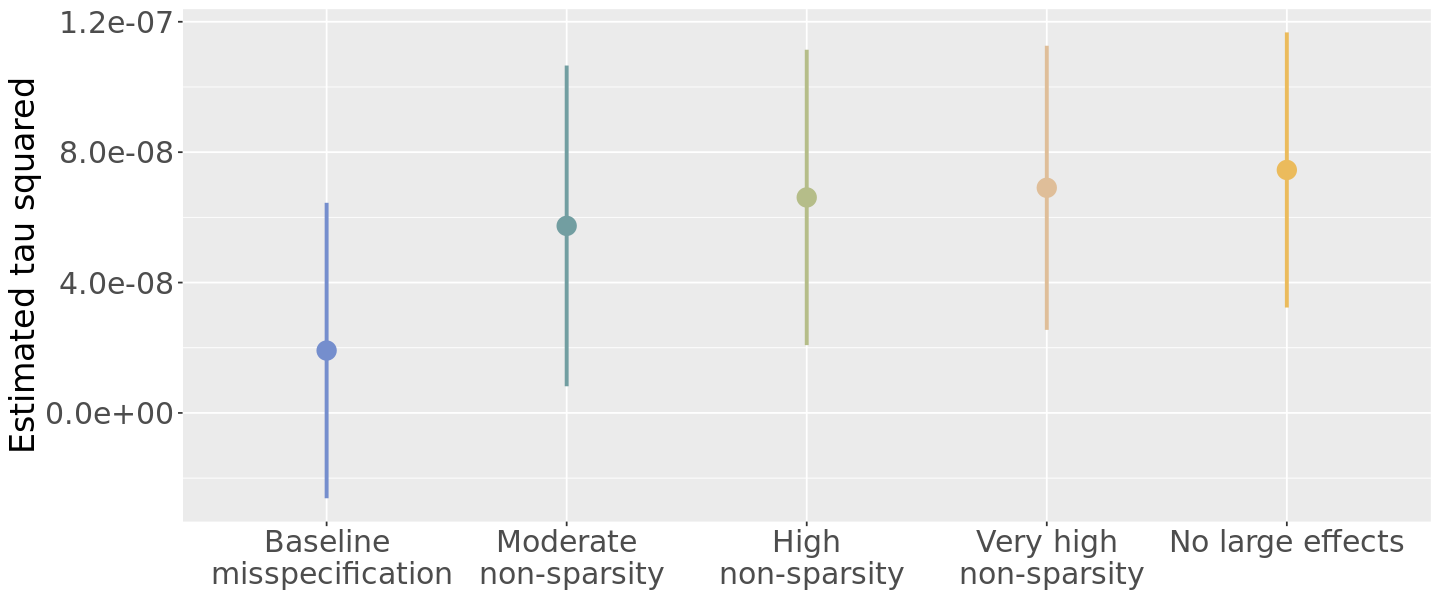

In [30]:
options(repr.plot.width=12, repr.plot.height=5)
pl_sim_tausq

# Extended Data Fig. 6

In [54]:
tausq = read_excel("Supplementary Tables.xlsx", sheet = 15)
ttest = read_excel("Supplementary Tables.xlsx", sheet = 16)
cs_tausq = read_excel("Supplementary Tables.xlsx", sheet = 17)
# box plots of tausq for 10 traits
pl_trait_tausq <- ggplot(tausq, aes(x=forcats::fct_reorder(trait, tausq, median), y=tausq, fill=trait)) +
  geom_boxplot(show.legend = FALSE) + 
  stat_summary(fun=mean, geom="point", shape=20, size=2.5, color="red", fill="red") +
  ylab("Tau-squared")+
  pl_theme + theme(axis.title.x=element_blank()) +
  scale_fill_manual(values=pheno_colors[unique(tausq$trait)])
# heatmap for pair-wise t-tests
trait_order = (tausq %>% group_by(trait) %>% summarize(median_tausq = median(tausq)) %>% arrange(desc(median_tausq)))$trait
ttest$mlog10p = -log10(ttest$pvalue)
ttest$trait1 = factor(ttest$trait1, levels = trait_order)
ttest$trait2 = factor(ttest$trait2, levels = trait_order)
ttest$sig_star = cut(ttest$pvalue, breaks=c(-Inf, 0.05/90, Inf), label=c("*", ""))
pl_heatmap <- ggplot(ttest, aes(x = trait1, y = trait2, fill = mlog10p)) +
  geom_tile(color = "black") +
  geom_text(aes(label=sig_star), color="orange", size=10) + 
  coord_fixed() + pl_theme + guides(fill=guide_legend(title="-log10(P-value)")) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
        axis.title=element_blank())
# median tausq and CS size
pl_cs_tausq <- ggscatter(cs_tausq, x = "cs", y = "tausq", 
          add = "reg.line", conf.int = TRUE, 
          cor.coef = TRUE, cor.method = "pearson", cor.coef.size = 10,
          xlab = "Number of credible sets in region", ylab = "Median tau-squared") + 
    pl_theme + scale_x_continuous(breaks= pretty_breaks())


New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`


`geom_smooth()` using formula 'y ~ x'



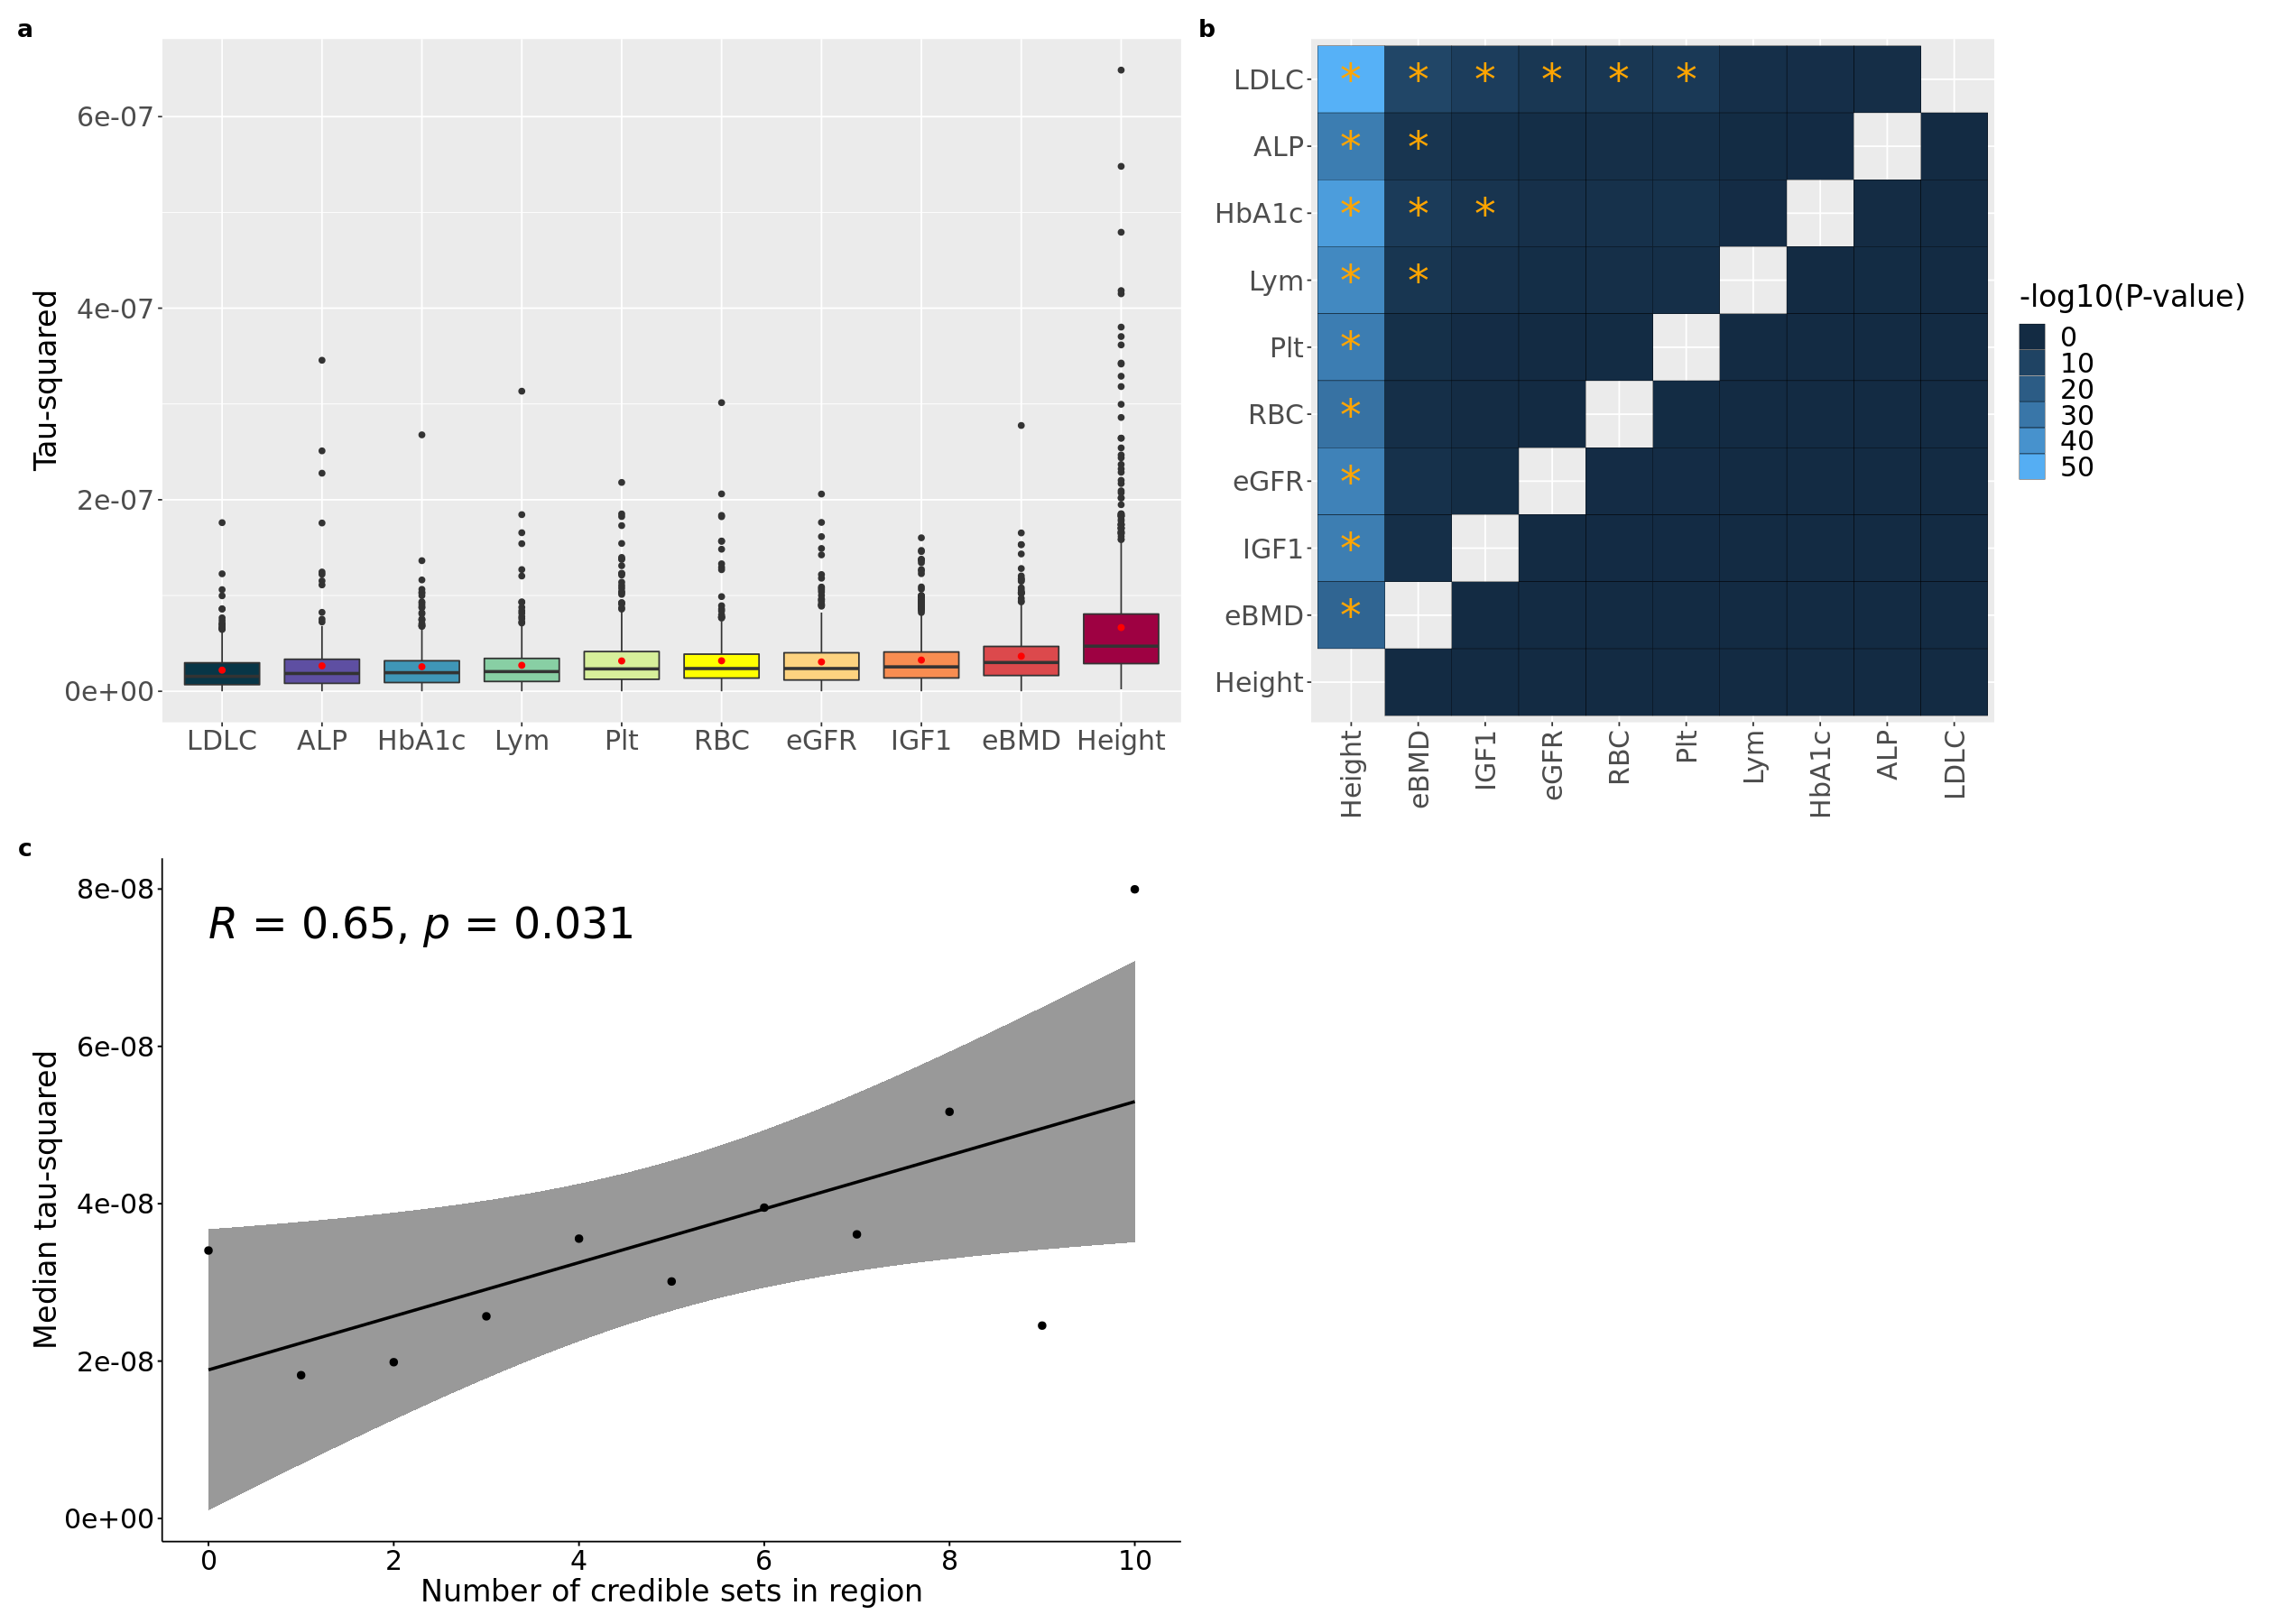

In [55]:
options(repr.plot.width=21, repr.plot.height=15)
layout <- "
AB
C#
"
supp_fig4 <- pl_trait_tausq + pl_heatmap + pl_cs_tausq +
 plot_layout(design=layout)+
 plot_annotation(tag_levels = "a") & theme(plot.tag = element_text(face = 'bold', size=16))
supp_fig4

# Extended Data Fig. 7

In [33]:
sf_pips = read_feather('/home/rancui/manuscript_v3.1/plot_data/ukbb_susie_finemap_pip01.feather')
sfinf_pips = read_feather('/home/rancui/manuscript_v3.1/plot_data/ukbb_susieinf_finemapinf_pip01.feather')
num_highpip = read_excel("Supplementary Tables.xlsx", sheet = 18)
num_highpip$alt_name = c('SuSiE','FINEMAP','minPIP', 'meanPIP', 
                         'SuSiE','FINEMAP','minPIP', 'meanPIP')
num_highpip$alt_name = factor(num_highpip$alt_name, levels=c('SuSiE','FINEMAP','minPIP', 'meanPIP'))
sf_cor = cor(sf_pips$prob_susie, sf_pips$prob_finemap)
sfinf_cor = cor(sfinf_pips$prob_susieinf, sfinf_pips$prob_finemapinf)
pl_sf <- ggplot(sf_pips, aes(x=prob_susie, y=prob_finemap) ) +
  geom_bin2d(bins = 50) + xlab('SuSiE PIP') + ylab('FINEMAP PIP') + 
  ggtitle(sprintf('Correlation %.2f', sf_cor)) +
  scale_fill_continuous(type = "viridis") + pl_theme + theme(legend.title=element_blank())
pl_sfinf <- ggplot(sfinf_pips, aes(x=prob_susieinf, y=prob_finemapinf)) + 
  geom_bin2d(bins=50) + xlab('SuSiE-inf PIP') + ylab('FINEMAP-inf PIP') +
  ggtitle(sprintf('Correlation %.2f', sfinf_cor)) +
  scale_fill_continuous(type="viridis") + pl_theme + theme(legend.title=element_blank())
pl_num_highpip <- ggplot(num_highpip, aes(fill=type, y=num_highpip, x=alt_name)) + 
    ylab('Number of high-PIP variants') +
    geom_bar(position="dodge", stat="identity") + pl_theme + theme(axis.title.x = element_blank(),
                                                                   legend.title=element_blank())

New names:
• `` -> `...1`


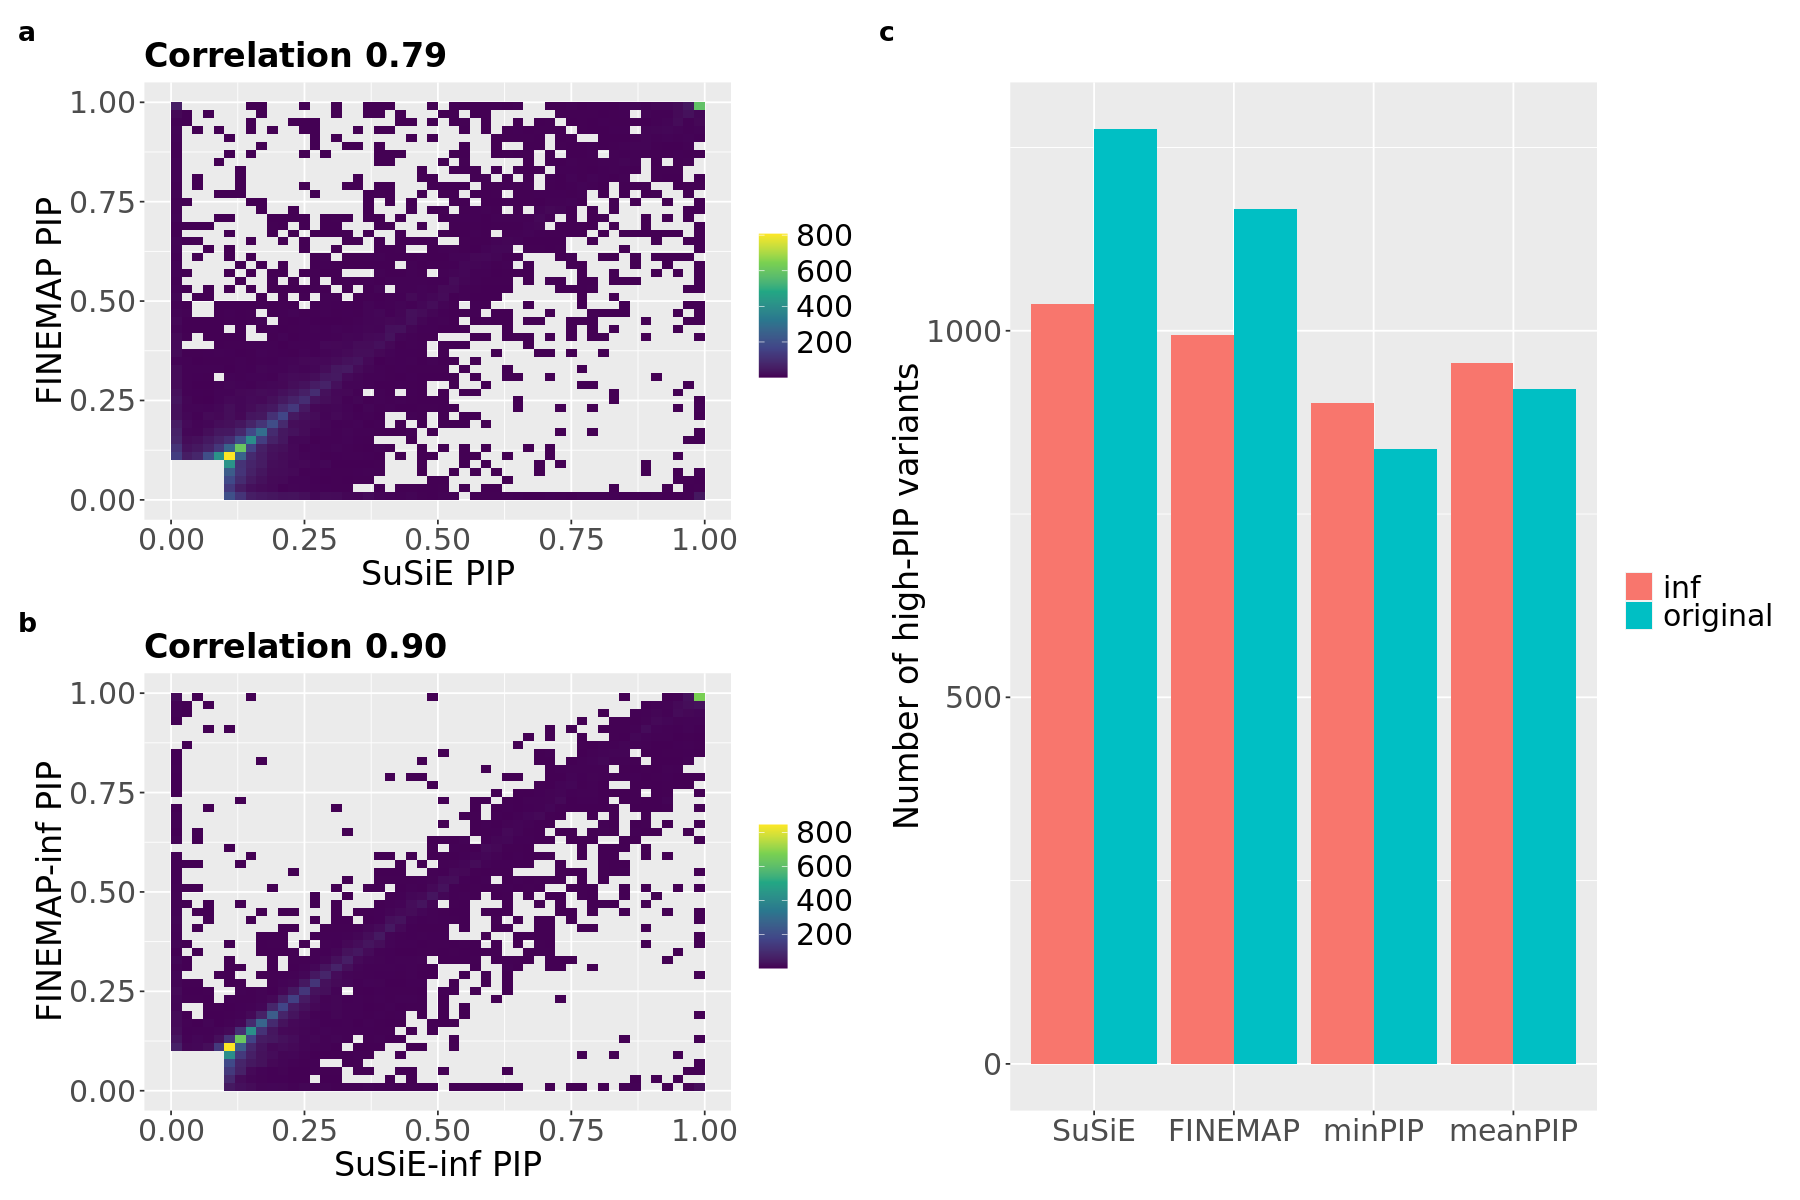

In [34]:
options(repr.plot.width=15, repr.plot.height=10)
layout <- "
AC
BC
"
supp_fig7 <- pl_sf + pl_sfinf + pl_num_highpip + plot_layout(design = layout)+
 plot_annotation(tag_levels = "a") & theme(plot.tag = element_text(face = 'bold', size=16))
supp_fig7

# Extended Data Fig. 8

In [35]:
# RFR plots
# Aggregated RFR plot
rfr_df = read_excel("Supplementary Tables.xlsx", sheet = 1)
all_rfr = rfr_df %>% dplyr::select('trait','method_name','n_highpip','rfr','epn','data.type') 
all_rfr$segment_legend='EPN'
# Compute Binomial proportion SD
all_rfr$std = sqrt((all_rfr$rfr)*(all_rfr$n_highpip)*(1-all_rfr$rfr))/all_rfr$n_highpip
# Filter to aggregated RFR
selected_method_names = c('SuSiE','FINEMAP','SuSiE-inf','FINEMAP-inf','minPIP','minPIP-inf')
data_to_plot = all_rfr %>% filter(trait=='agg') %>% filter(method_name %in% selected_method_names)
data_to_plot$method_name <- factor(data_to_plot$method_name, levels = selected_method_names)
data_to_plot$data.type <- factor(data_to_plot$data.type, levels=c('Real data','Ideal simulation'))
# Compute EPN line segment positions
num_methods = length(selected_method_names)
barwidth = 0.85/num_methods
pos_dodge = 1
xstart = c(seq(1-barwidth*num_methods/2,1+barwidth*num_methods/2-barwidth,length.out=num_methods),
  seq(1-barwidth*num_methods/2+pos_dodge, 1+barwidth*num_methods/2-barwidth+pos_dodge, length.out=num_methods))
xend = c(seq(1-barwidth*num_methods/2+barwidth,1+barwidth*num_methods/2,length.out=num_methods),
  seq(1-barwidth*num_methods/2+barwidth+pos_dodge,1+barwidth*num_methods/2+pos_dodge,length.out=num_methods))
# Plot
pl_rfr = ggplot(data=data_to_plot, aes(x=data.type, y=rfr, fill=method_name)) +
    geom_bar(position=position_dodge(), color='black', stat="identity",width=0.85) + 
    geom_segment(data=data_to_plot, aes(x=xstart, y=epn, 
                 xend=xend, yend=epn, 
                 color=method_name,linetype=`segment_legend`), 
                 size=1,color='black',inherit.aes = FALSE)+
    geom_errorbar(aes(ymin=rfr-std, ymax=rfr+std),position=position_dodge(.85),width=0.2)+
    ylab(label = "Replication failure rate")+
    scale_linetype_manual("EPN",values=c("EPN"=1.5))+
    scale_fill_manual(values=method_colors[selected_method_names])+
    pl_theme + theme(axis.title.x = element_blank(),
                     legend.title = element_blank())

New names:
• `` -> `...1`


In [36]:
# Top N SNPs enrichment plot
top_n = read_excel("Supplementary Tables.xlsx", sheet = 12)
selected_methods = c('SuSiE-inf','FINEMAP-inf','minPIP-inf') 
top_n = (top_n %>% filter(method_name %in% selected_methods) %>% mutate(coding=(LoF + missense))
                            %>% mutate('putative regulatory'=(synonymous+UTR3+UTR5+promoter+CRE+conserved))
                            %>% dplyr::select(top_N, method_name, coding, 'putative regulatory', 'non-genic'))
melted_data <-  reshape2::melt(top_n , id.vars = c("top_N","method_name"), measure.vars = simple_annot_names)
data <- melted_data %>% group_by(top_N,method_name)
data <- mutate(data, prop = value / sum(value), 
               std = sqrt(sum(value)*(value/sum(value))*(1-(value/sum(value))))/sum(value),
               sd_pos = cumsum(prop))
data$method_name<-factor(data$method_name, levels= selected_methods)
data$variable <- factor(data$variable,levels=simple_annot_names)
pl_top_n <- qplot(x = method_name, y = prop, fill = variable, data = data, geom = "col") +
geom_errorbar(aes(x=method_name,ymin=1-prop+std,ymax=1-prop-std),width=.1, 
              data=data %>% filter(variable=='non-genic'),
              inherit.aes = FALSE)+
facet_wrap(~top_N)+
ggtitle('Top N variants functional enrichment')+
scale_fill_manual(values = simple_annot_colors) +
pl_theme + coord_flip() + theme(axis.title=element_blank(),
                                legend.title=element_blank())

New names:
• `` -> `...1`


In [37]:
# PRS plots
prs_df = read_excel("Supplementary Tables.xlsx", sheet = 7)
p1_to_plot <- prs_df %>% filter(method_name %in% c('SuSiE-inf','minPIP-inf')) %>%
    reshape2::dcast(trait+cohort ~ method_name, value.var = "delta_r2") %>%
    na.omit()
p1 = ggplot(p1_to_plot,
       aes(x=`SuSiE-inf`,y=`minPIP-inf`, color=trait, shape=cohort)) +
    geom_point(size=point_size)+
    geom_abline(slope=1)+
    xlim(-0.001,NA)+ylim(-0.001,NA)+
    ggtitle('Delta R2 using SuSiE-inf v.s. minPIP-inf')+
    xlab('SuSiE-inf')+ylab('minPIP-inf')+
    scale_color_manual(values=pheno_colors[unique(plot_df$trait)])+
    pl_theme
# FINEMAP and FINEMAPinf
p2_to_plot <- prs_df %>% filter(method_name %in% c('FINEMAP-inf','minPIP-inf')) %>%
    reshape2::dcast(trait+cohort ~ method_name, value.var = "delta_r2") %>%
    na.omit()
p2 = ggplot(p2_to_plot,
       aes(x=`FINEMAP-inf`,y=`minPIP-inf`, color=trait,shape=cohort)) +
    geom_point(size=point_size)+
    geom_abline(slope=1)+
    xlim(-0.001,NA)+ylim(-0.001,NA)+
    ggtitle('Delta R2 using FINEMAP-inf v.s. minPIP-inf') +
    xlab('FINEMAP-inf')+ylab('minPIP-inf')+
    scale_color_manual(values=pheno_colors[unique(plot_df$trait)])+
    pl_theme

pl_prs = p1 + p2  + plot_layout(ncol = 2, guides = "collect") +
plot_annotation(
  title = "PRS delta R2 comparisons",
  theme = theme(plot.title = element_text(size = 20,face='bold',hjust=0.4))
)

New names:
• `` -> `...1`


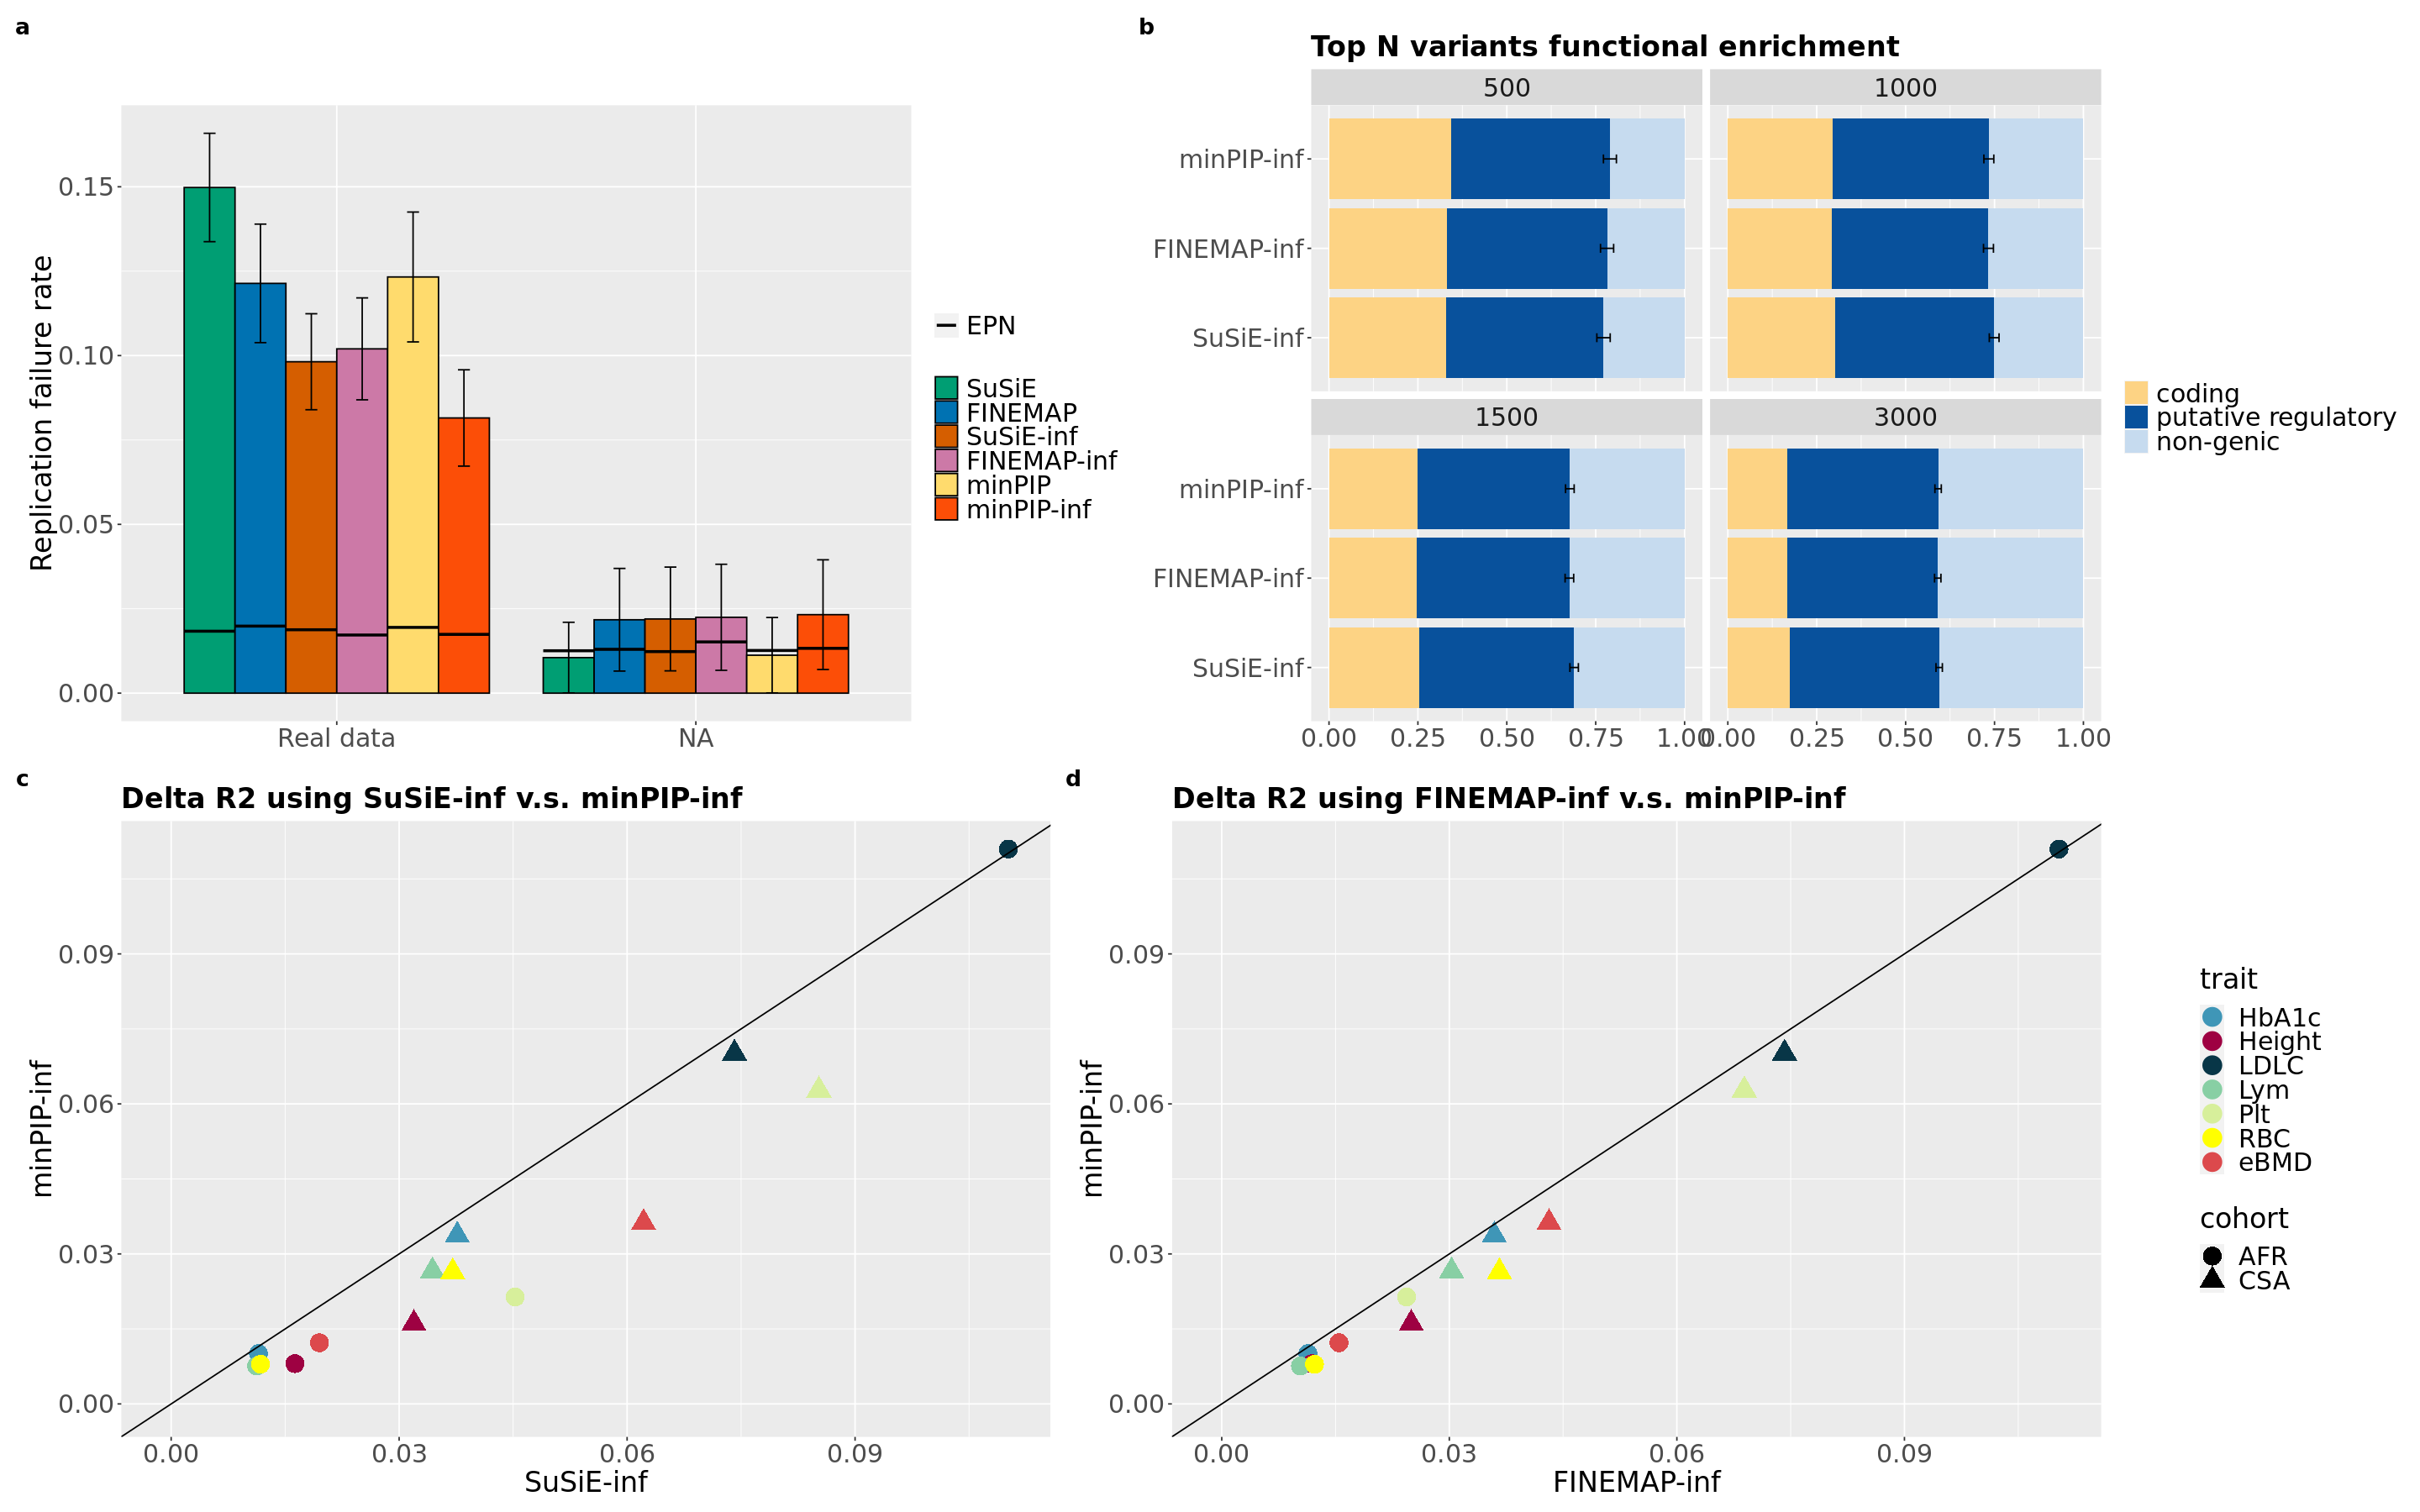

In [38]:
options(repr.plot.width=24, repr.plot.height=15)
layout <- "
AB
CC
"
supp_fig8 <- pl_rfr + pl_top_n +pl_prs + plot_layout(design = layout)+
 plot_annotation(tag_levels = "a") & theme(plot.tag = element_text(face = 'bold', size=16))
supp_fig8

# Extended Data Fig. 9

In [39]:
rfr_df = read_excel("Supplementary Tables.xlsx", sheet = 1)
all_rfr = rfr_df %>% dplyr::select('trait','method_name','n_highpip','rfr','epn','data.type')
all_rfr$segment_legend='EPN'
# Compute Binomial proportion SD
all_rfr$std = sqrt((all_rfr$rfr)*(all_rfr$n_highpip)*(1-all_rfr$rfr))/all_rfr$n_highpip
# Filter to aggregated RFR
selected_method_names = c('SuSiE','FINEMAP','COJO-ABF','ABF')
data_to_plot = all_rfr %>% filter(trait=='agg') %>% filter(method_name %in% selected_method_names)
data_to_plot$method_name <- factor(data_to_plot$method_name, levels = selected_method_names)
data_to_plot$data.type <- factor(data_to_plot$data.type, levels=c('Real data','Ideal simulation'))
# Compute EPN line segment positions
num_methods = length(selected_method_names)
barwidth = 0.85/num_methods
pos_dodge = 1
xstart = c(seq(1-barwidth*num_methods/2,1+barwidth*num_methods/2-barwidth,length.out=num_methods),
  seq(1-barwidth*num_methods/2+pos_dodge, 1+barwidth*num_methods/2-barwidth+pos_dodge, length.out=num_methods))
xend = c(seq(1-barwidth*num_methods/2+barwidth,1+barwidth*num_methods/2,length.out=num_methods),
  seq(1-barwidth*num_methods/2+barwidth+pos_dodge,1+barwidth*num_methods/2+pos_dodge,length.out=num_methods))
# Plot
pl_rfr = ggplot(data=data_to_plot, aes(x=data.type, y=rfr, fill=method_name)) +
    geom_bar(position=position_dodge(), color='black', stat="identity",width=0.85) + 
    geom_segment(data=data_to_plot, aes(x=xstart, y=epn, 
                 xend=xend, yend=epn, 
                 color=method_name,linetype=`segment_legend`), 
                 size=1,color='black',inherit.aes = FALSE)+
    geom_errorbar(aes(ymin=rfr-std, ymax=rfr+std),position=position_dodge(.85),width=0.2)+
    ylab(label = "Replication failure rate")+
    scale_linetype_manual("EPN",values=c("EPN"=1.5))+
    scale_fill_manual(values=method_colors[selected_method_names])+
    pl_theme + theme(axis.title.x = element_blank(),
                     legend.title = element_blank())

New names:
• `` -> `...1`


In [40]:
func_enrich = read_excel("Supplementary Tables.xlsx", sheet = 2)
selected_methods = c('SuSiE','FINEMAP','COJO-ABF','ABF')
selected_groups = c('Non-replicating','Replicated',"Matched on PIP at 100K",
                    "Matched on PIP at 366K", 'Background')
pl_list = list()
for (m in selected_methods){
    # collapse categories
    func_enrich_selected = (func_enrich %>% filter(method_name==m)
                            %>% filter(type %in% selected_groups)
                            %>% mutate(coding=(LoF + missense))
                            %>% mutate("putative regulatory"=(synonymous+UTR3+UTR5+promoter+CRE+conserved))
                            %>% dplyr::select(type, coding, "putative regulatory", "non-genic"))
    # aggregate methods
    agg_methods <- func_enrich_selected %>% group_by(type) %>% summarise(across(all_of(simple_annot_names), sum))
    data <- as.data.frame(agg_methods)
    melted_data <-  reshape2::melt(data , id.vars = c("type"), measure.vars = simple_annot_names)
    data <- group_by(melted_data,type)
    data <- mutate(data, prop = value / sum(value), 
                   std = sqrt(sum(value)*(value/sum(value))*(1-(value/sum(value))))/sum(value),
                   sd_pos = cumsum(prop))
    data$type<-factor(data$type, levels= selected_groups)
    data$variable <- factor(data$variable,levels=simple_annot_names)
    # plot
    pl_list[[m]] <- qplot(x = type, y = prop, fill = variable, data = data, geom = "col") +
        geom_errorbar(aes(x=type,ymin=1-prop+std,ymax=1-prop-std),width=.1, 
                  data=data %>% filter(variable=='non-genic'),
                  inherit.aes = FALSE)+
        ggtitle(m) +
        scale_fill_manual(values = simple_annot_colors) +
        pl_theme + theme(plot.title = element_text(hjust=0.4),
                         axis.title.y=element_blank(),
                         axis.title.x=element_blank(),
                         legend.title=element_blank()) + coord_flip()
}

New names:
• `` -> `...1`


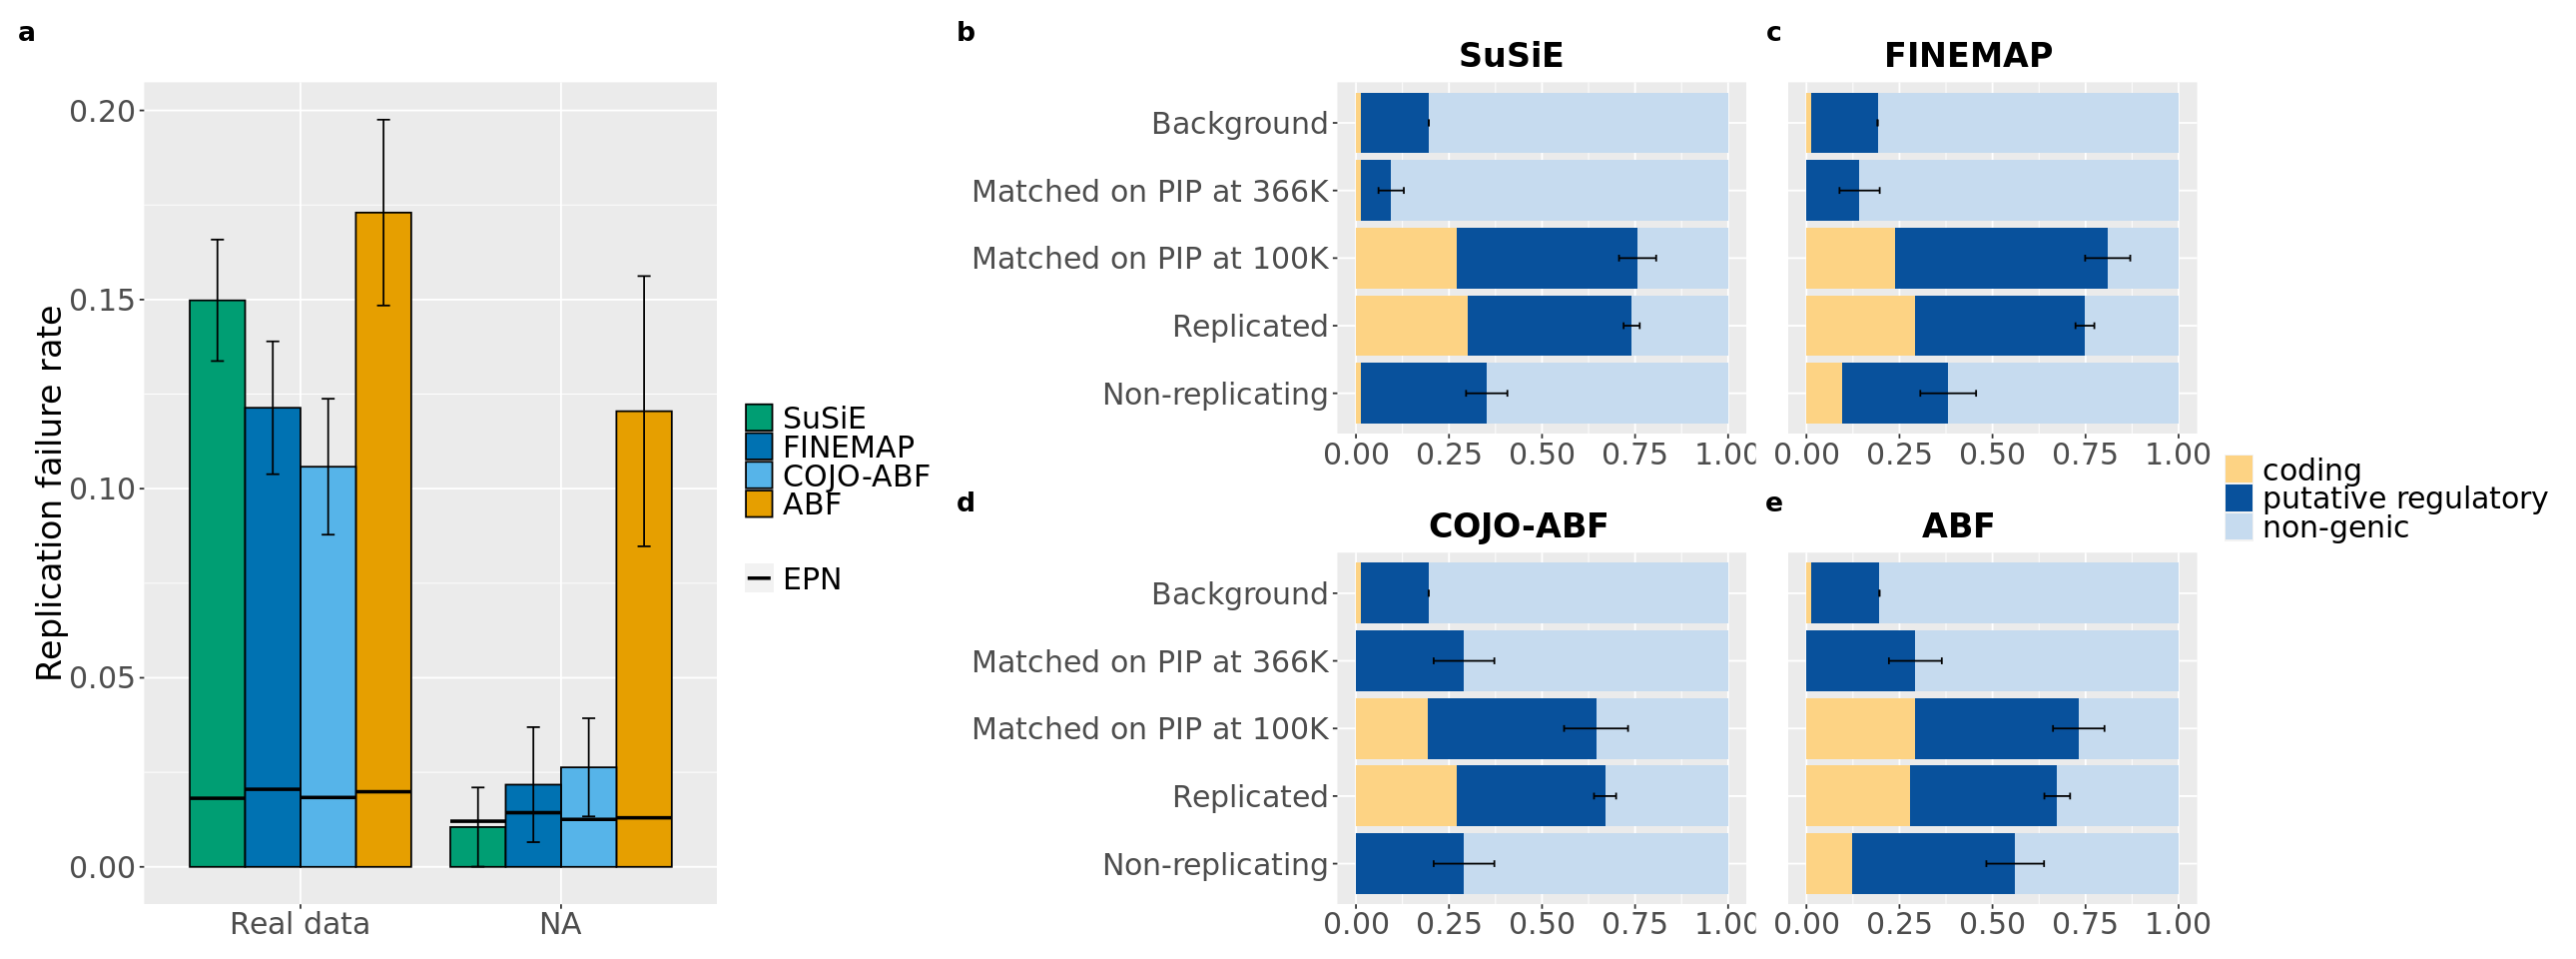

In [41]:
options(repr.plot.width=21.5, repr.plot.height=8)
pl_list[[2]] = pl_list[[2]] + theme(axis.text.y = element_blank(),
                         axis.ticks.y = element_blank(),
                         axis.title.y = element_blank())
pl_list[[4]] = pl_list[[4]] + theme(axis.text.y = element_blank(),
                         axis.ticks.y = element_blank(),
                         axis.title.y = element_blank())
pl_enrich_sep = pl_list[[1]] + pl_list[[2]] +  pl_list[[3]] + pl_list[[4]] + plot_layout(ncol=2,guides = "collect")

layout <- "
AABBB
"
supp_fig9 <- pl_rfr + pl_enrich_sep + plot_layout(design = layout)+
 plot_annotation(tag_levels = "a") & theme(plot.tag = element_text(face = 'bold', size=16))
supp_fig9

# Extended Data Fig. 10

In [42]:
# Calibration
calib = read_excel("Supplementary Tables.xlsx", sheet = 19)
selected_method_names = c('SuSiE','FINEMAP','ABF','COJO-ABF')
calib[,c('mean','lower','upper')] = binom.confint(calib$num_causal,calib$num_snps, 
                                                   conf.level=0.95, methods='exact')[,c('mean','lower','upper')]
calib$bin <- factor(calib$bin, levels=c('[0,0.01]','(0.01,0.1]','(0.1,0.5]','(0.5,0.9]','(0.9,1]'))
options(repr.plot.width=10, repr.plot.height=6)
pl_calib <- ggplot(calib %>% filter(method_name %in% selected_method_names) , aes(bin, prop_causal)) +
    geom_pointrange(
        aes(ymin = lower, ymax = upper, color = method_name),
        position = position_dodge(1),
        size=1)+
    geom_hpline(aes(bin, mean_pip, shape=method_name), 
                position=position_dodge(1), size = 1.5, 
                width = 0.2,inherit.aes = FALSE)+
    ggtitle('Calibration in baseline simulations')+
    ylab('Proportion causal')+
    xlab("PIP bins") + pl_theme + theme(legend.title=element_blank())+
    scale_color_manual(values=method_colors[selected_method_names])
# Recall
recall_df = read_excel("Supplementary Tables.xlsx", sheet = 20)
recall_df[,c('mean','lower','upper')] = binom.confint(recall_df$n_causal,recall_df$tot_causal, 
                                                   conf.level=0.95, methods='exact')[,c('mean','lower','upper')]
recall_df$top_perc = factor(recall_df$top_perc)
selected_names = c('ABF','COJO-ABF','SuSiE','FINEMAP')
pl_recall <- ggplot(recall_df %>% filter(method_name %in% selected_names), aes(top_perc, mean)) +
    geom_pointrange(
        aes(ymin = lower, ymax = upper, color = method_name),
        position = position_dodge(0.3), size=1)+ 
    scale_color_manual(values=method_colors[selected_method_names])+
    ylab('Recall')+
    xlab("Top percentage of variants") + pl_theme + theme(legend.title=element_blank())
# Number of causal in false positive regions
num_snps_df = read_excel("Supplementary Tables.xlsx", sheet = 21)
num_snps_df[num_snps_df=='Regions contain false positive SNPs'] = 'False positive regions'
pl_false_pos <- ggplot(num_snps_df, aes(x=causal, color=type)) + 
 geom_histogram(aes(y=..density..), fill="white", alpha=0.4, position="identity",binwidth=1)+
 xlab('Number of causal variants in region') +
 ylab('Density')+
scale_x_continuous(breaks= pretty_breaks()) + pl_theme + theme(legend.title=element_blank())

New names:
• `` -> `...1`
Warning message:
“Ignoring unknown aesthetics: shape”
New names:
• `` -> `...1`
New names:
• `` -> `...1`


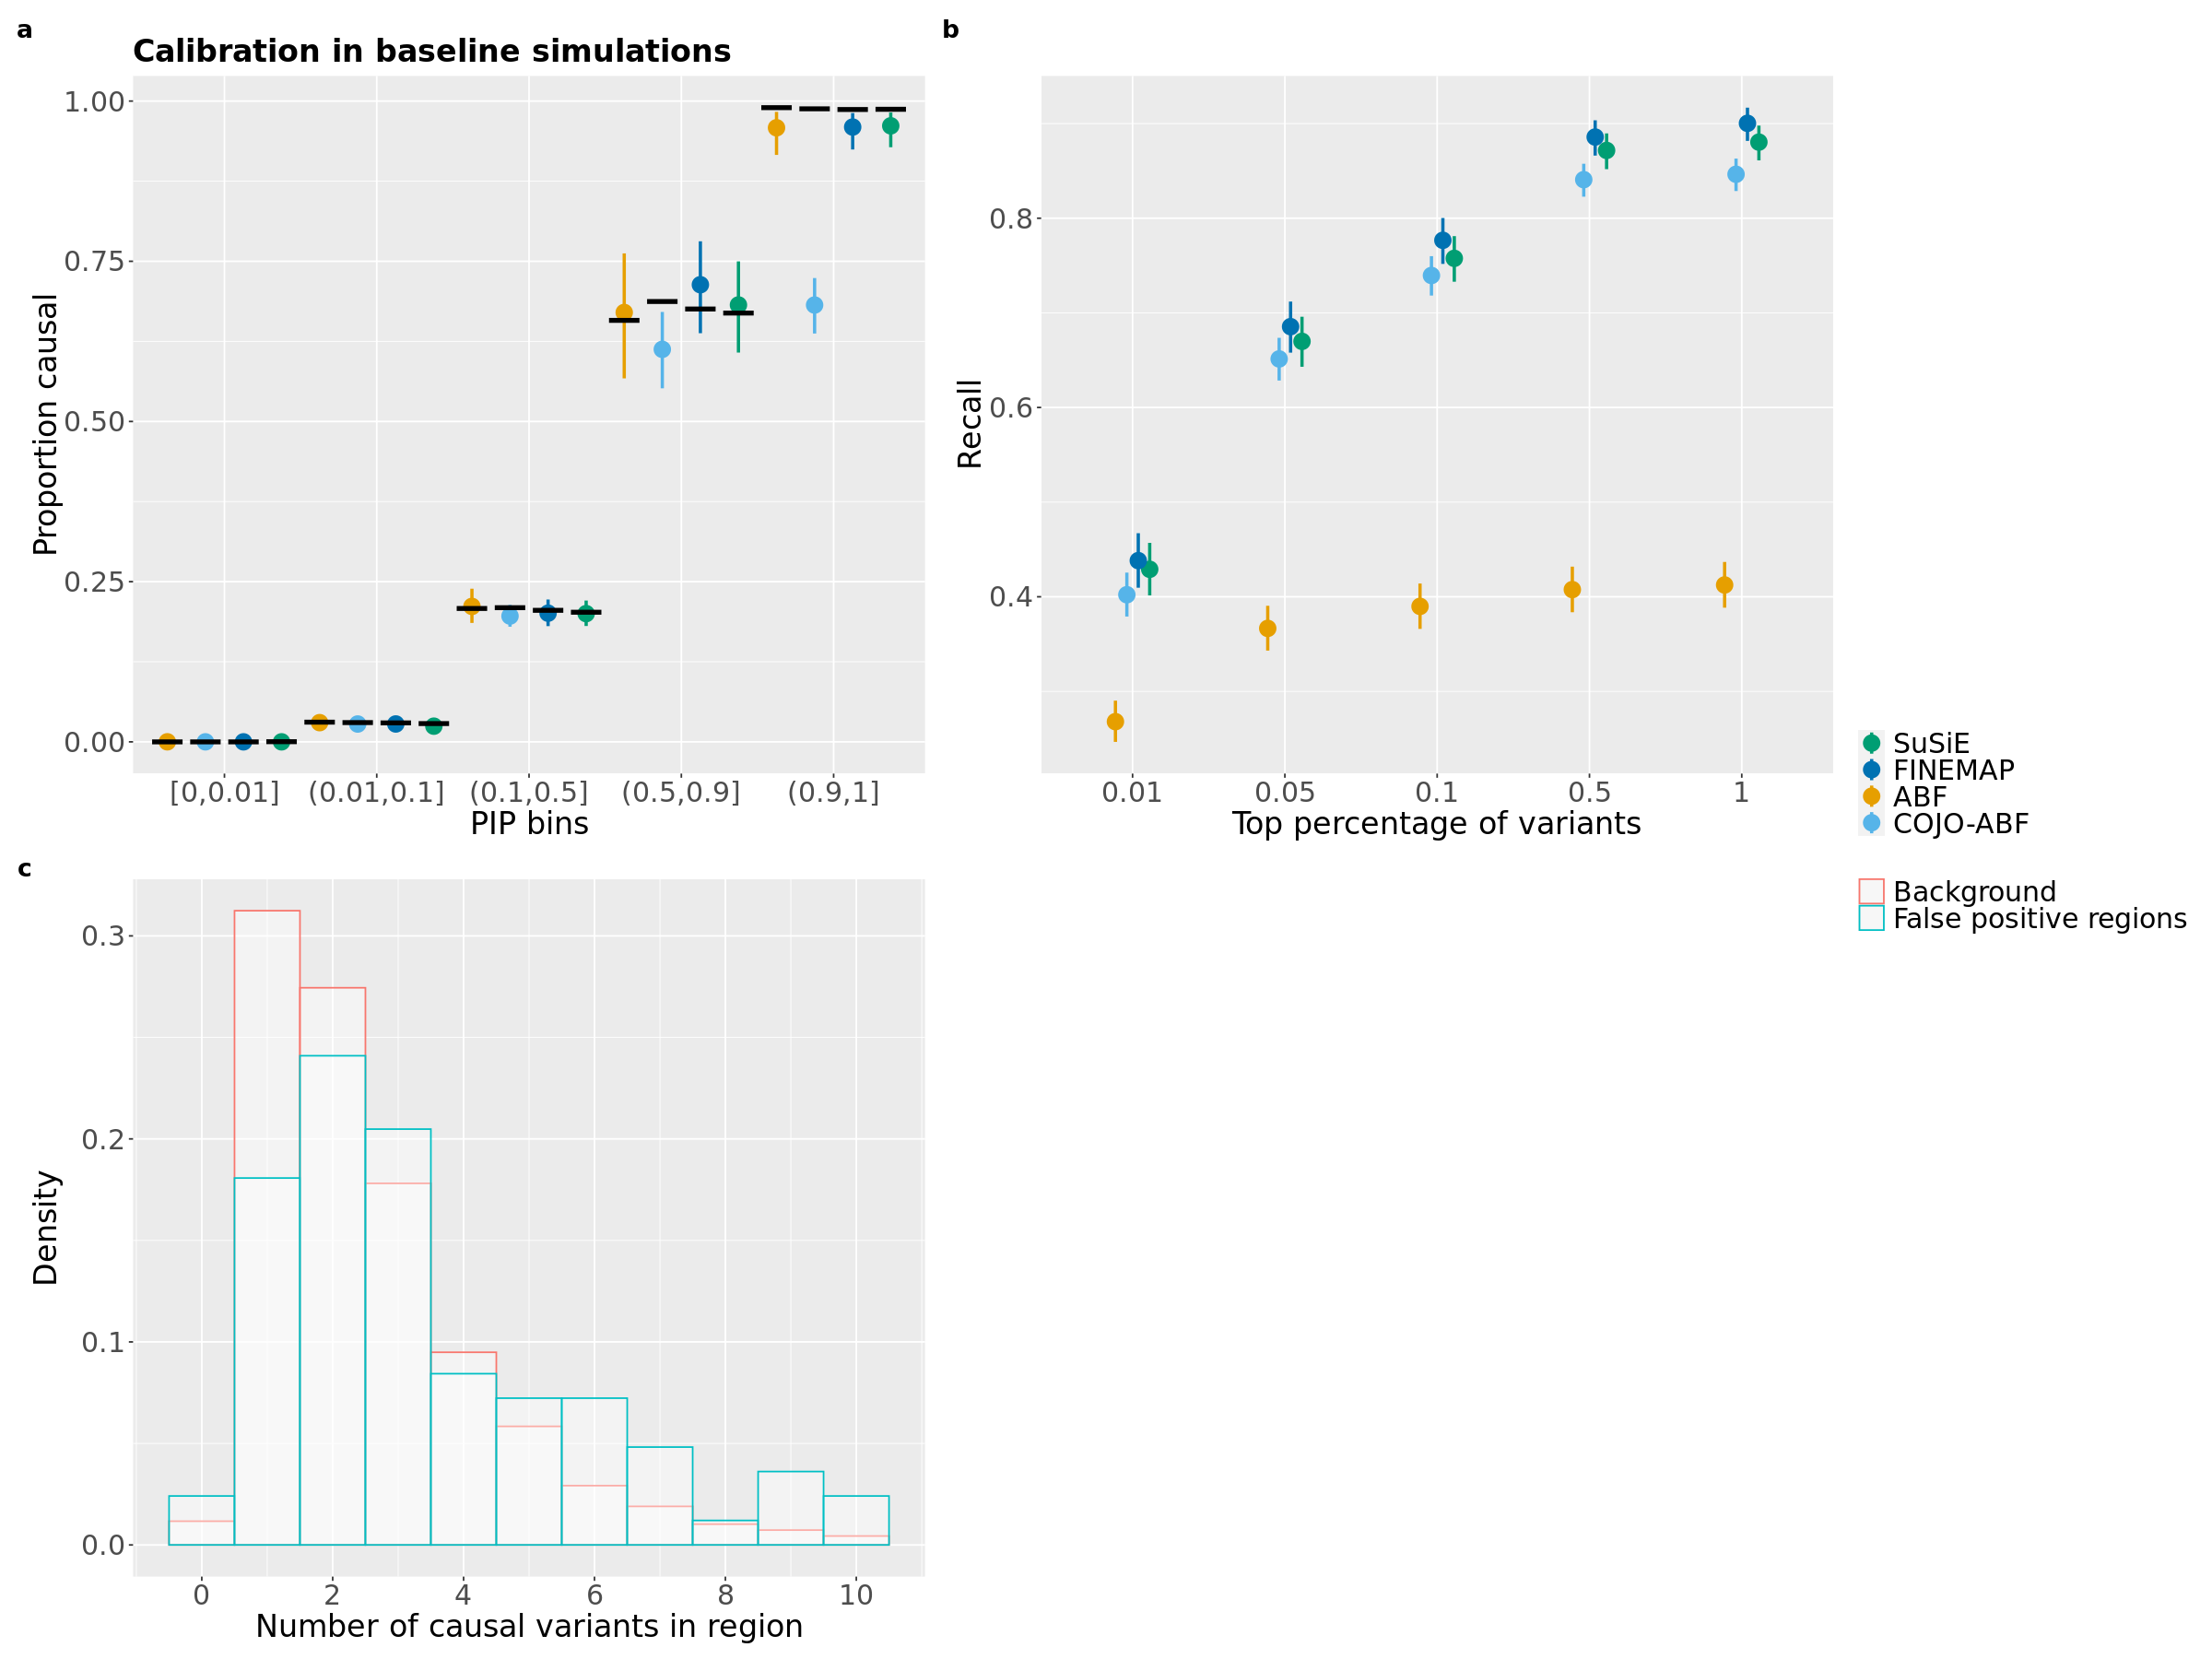

In [43]:
options(repr.plot.width=20, repr.plot.height=15)
calib_recall = pl_calib + pl_recall + plot_layout(ncol=2, guides="collect")

layout <- "
AB
C#
"
supp_fig10 <- calib_recall + pl_false_pos + plot_layout(design=layout)+
 plot_annotation(tag_levels = "a") & theme(plot.tag = element_text(face = 'bold', size=16))
supp_fig10

# Supplementary Fig. 1

In [44]:
venn_df = read_excel("Supplementary Tables.xlsx", sheet = 24)
x = list(
    'SuSiE' = (venn_df %>% filter(method=='susie'))$id,
    'SuSiE-inf' = (venn_df %>% filter(method=='susieinf'))$id,
    'FINEMAP' = (venn_df %>% filter(method=='finemap'))$id,
    'FINEMAP-inf' = (venn_df %>% filter(method=='finemapinf'))$id)
pl_venn <-  ggvenn(
  x, 
  fill_color = c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF"),
  stroke_size = 0.5, set_name_size = 5
  ) + pl_theme + 
    theme(axis.title=element_blank(),axis.text = element_blank())

New names:
• `` -> `...1`


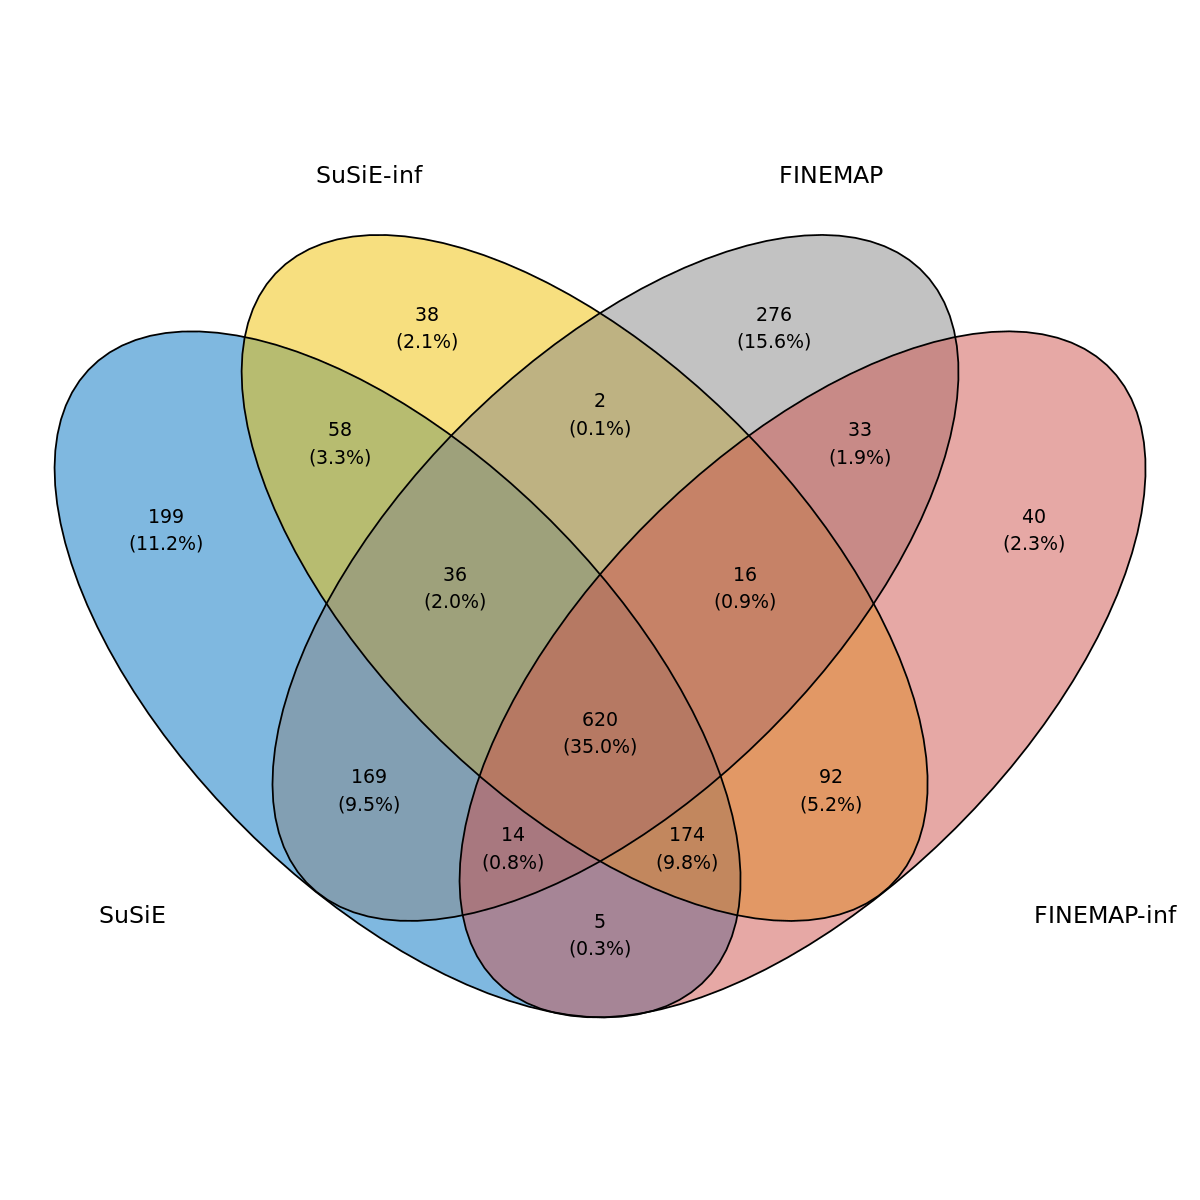

In [45]:
options(repr.plot.width=10, repr.plot.height=10)
pl_venn

# Supplementary Fig. 2

In [46]:
ht_bolt_ols_366k_to_plot = read_feather('/home/rancui/manuscript_v3.1/plot_data/ht_bolt_ols_366k_to_plot.feather')
ht_bolt_ols_100k_to_plot = read_feather('/home/rancui/manuscript_v3.1/plot_data/ht_bolt_ols_100k_to_plot.feather')
ht_bolt_280k_ols_366k_to_plot = read_feather('/home/rancui/manuscript_v3.1/plot_data/ht_bolt_280k_ols_366k_to_plot.feather')
ht_bolt_88k_ols_100k_to_plot = read_feather('/home/rancui/manuscript_v3.1/plot_data/ht_bolt_88k_ols_100k_to_plot.feather')
pl_366k <- ggscatter(ht_bolt_ols_366k_to_plot, y = "CHISQ_BOLT_LMM_INF", x = "chisq", 
          add = "reg.line", conf.int = TRUE, 
          cor.coef = TRUE, cor.method = "pearson", cor.coef.size = 10,
          ylab = "BOLT marginal chi-squared statistics", 
          xlab = "OLS marginal chi-squared statistics",
          title = "N=366K") + pl_theme + 
          scale_x_continuous(breaks = c(0,500, 1000), labels = c('0','500','1000'))
pl_100k <- ggscatter(ht_bolt_ols_100k_to_plot, y = "CHISQ_BOLT_LMM_INF", x = "chisq", 
          add = "reg.line", conf.int = TRUE, 
          cor.coef = TRUE, cor.method = "pearson", cor.coef.size = 10,
          ylab = "BOLT marginal chi-squared statistics", 
          xlab = "OLS marginal chi-squared statistics",
          title = "N=100K") + pl_theme + 
          scale_x_continuous(breaks= pretty_breaks())
pl_280k <- ggscatter(ht_bolt_280k_ols_366k_to_plot, y = "CHISQ_BOLT_LMM_INF", x = "chisq", 
          add = "reg.line", conf.int = TRUE, 
          cor.coef = TRUE, cor.method = "pearson", cor.coef.size = 10,
          ylab = "BOLT marginal chi-squared statistics at N=280K", 
          xlab = "OLS marginal chi-squared statistics at N=366K") + 
          pl_theme + scale_x_continuous(breaks = c(0,500, 1000), labels = c('0','500','1000'))
pl_88k <- ggscatter(ht_bolt_88k_ols_100k_to_plot, y = "CHISQ_BOLT_LMM_INF", x = "chisq", 
          add = "reg.line", conf.int = TRUE, 
          cor.coef = TRUE, cor.method = "pearson", cor.coef.size = 10,
          ylab = "BOLT marginal chi-squared statistics at N=88K", 
          xlab = "OLS marginal chi-squared statistics at N=100K") + 
          pl_theme

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



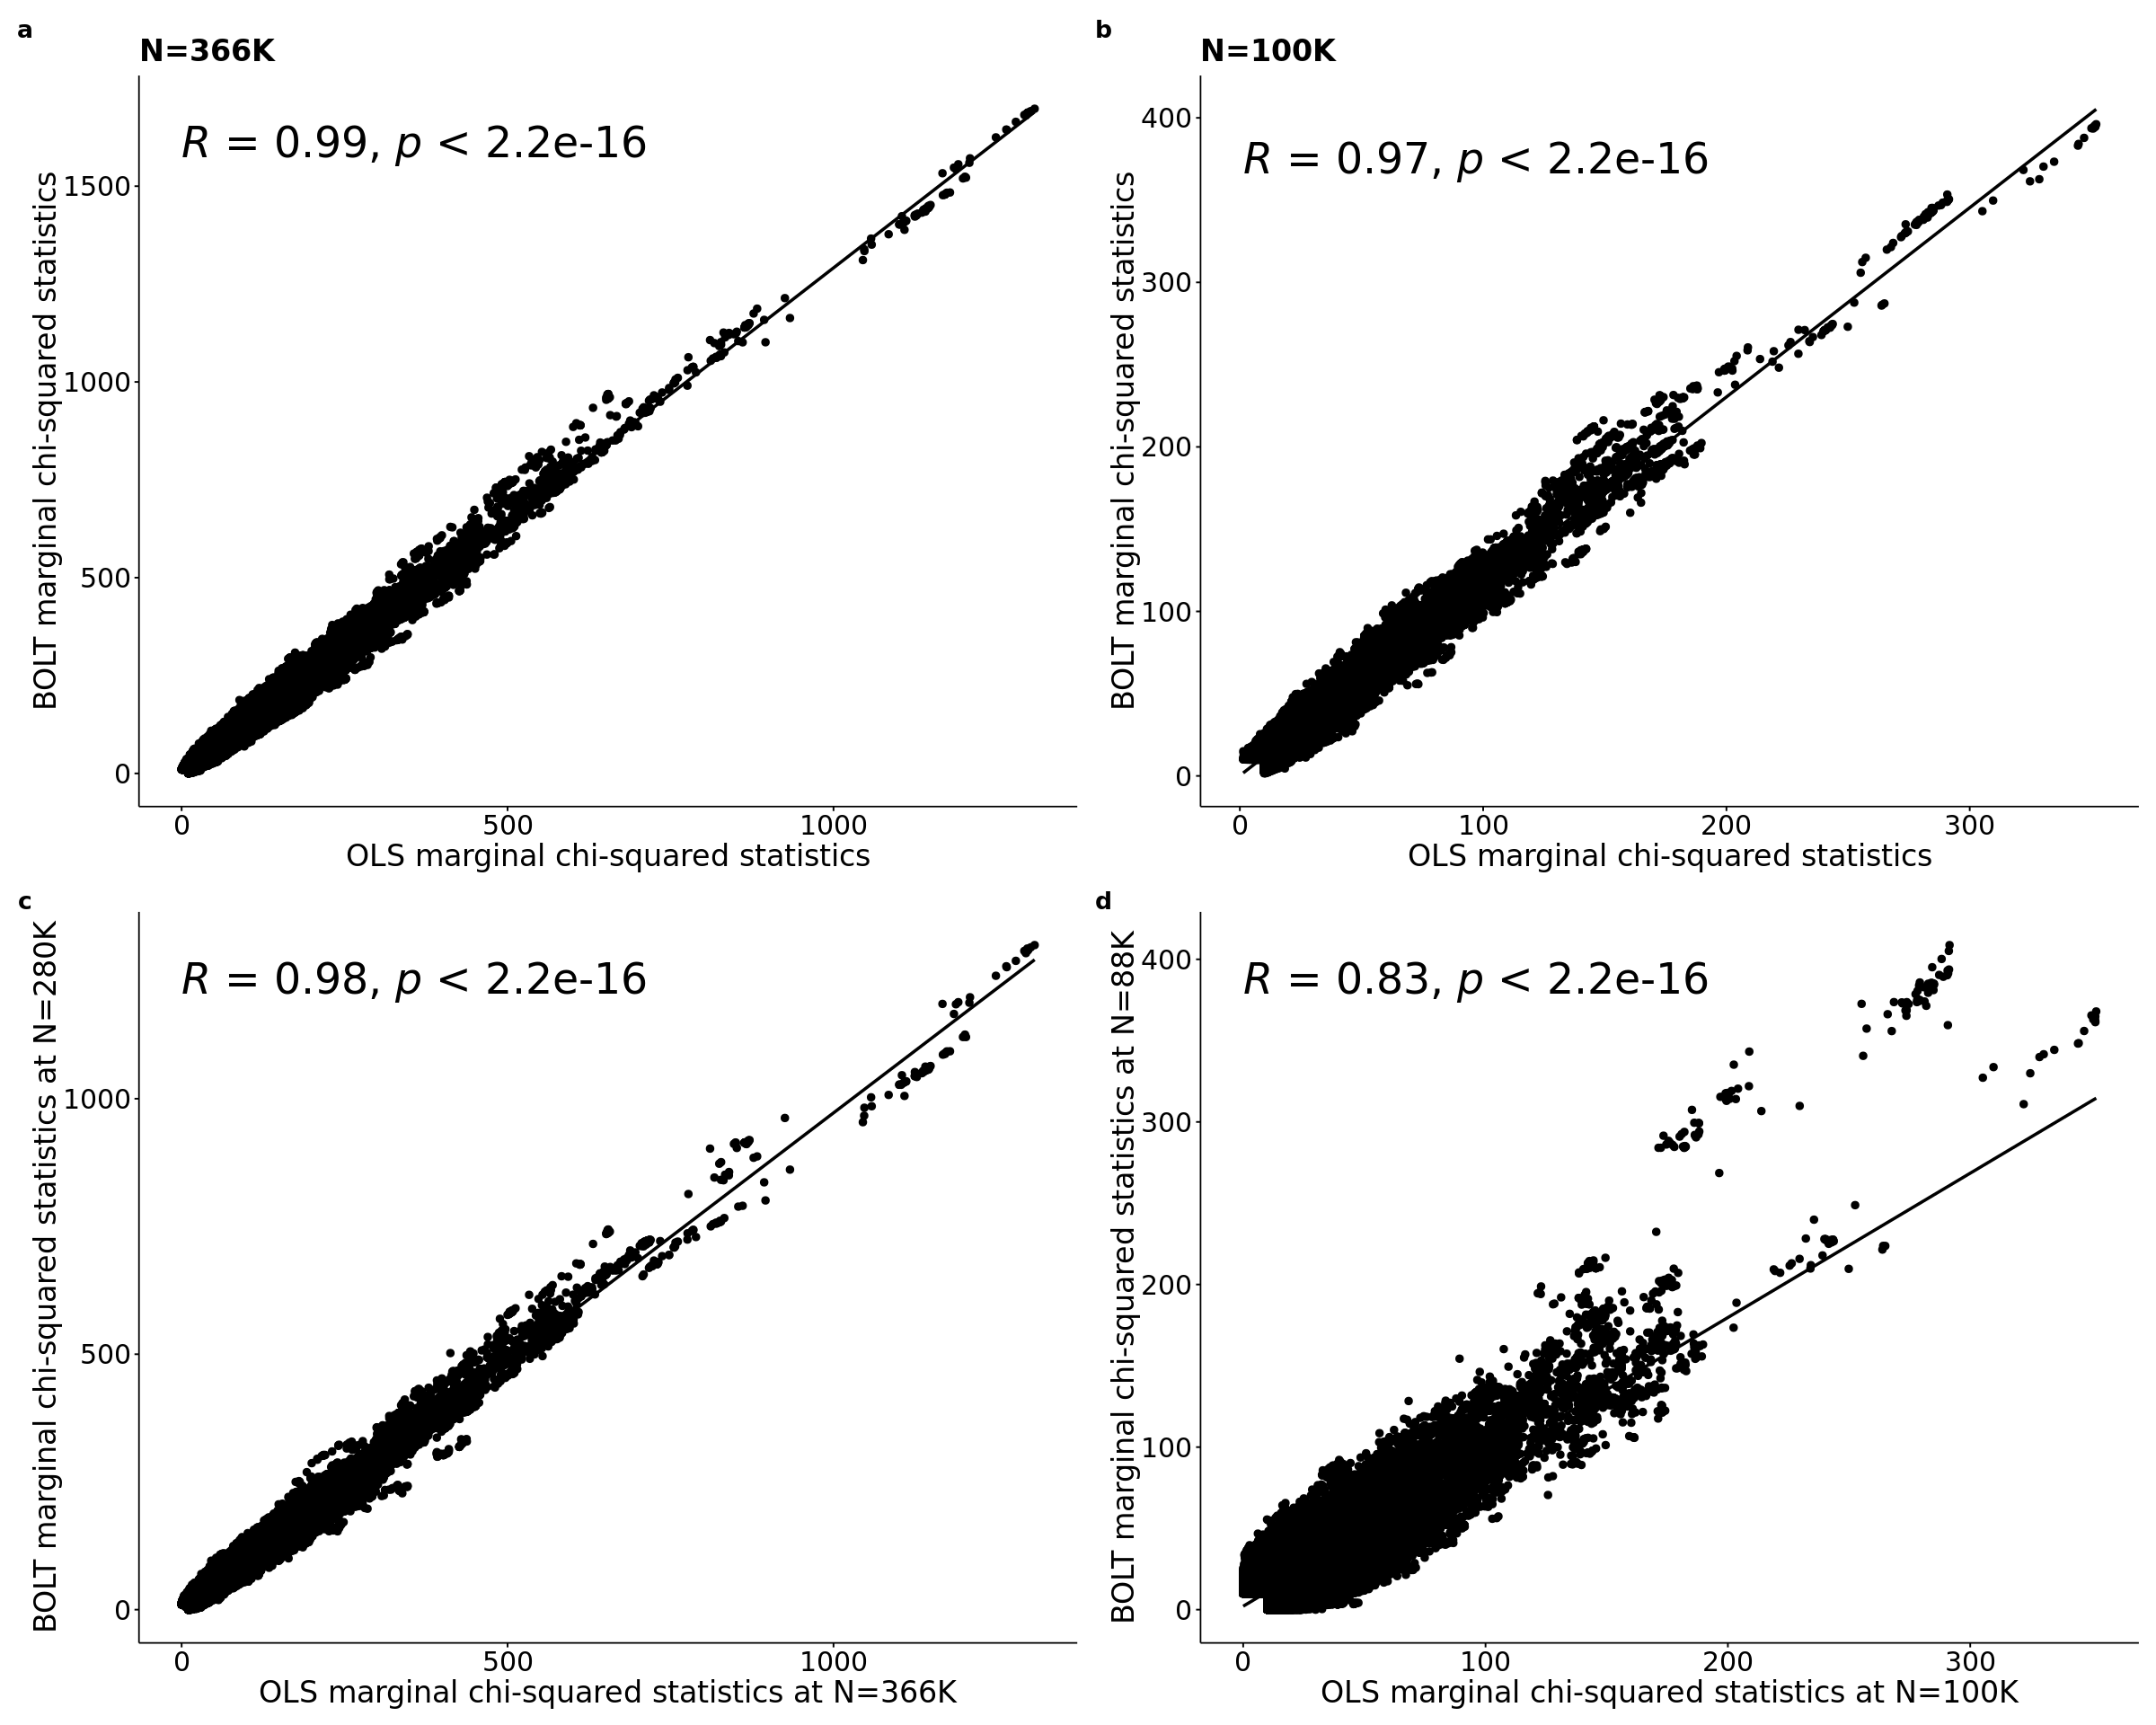

In [47]:
options(repr.plot.width=20, repr.plot.height=16)
layout <- "
AB
CD
"
supp_fig12 <- pl_366k + pl_100k + pl_280k + pl_88k +
 plot_layout(design=layout)+
 plot_annotation(tag_levels = "a") & theme(plot.tag = element_text(face = 'bold', size=16))
supp_fig12

# Supplementary Fig. 3

New names:
• `` -> `...1`


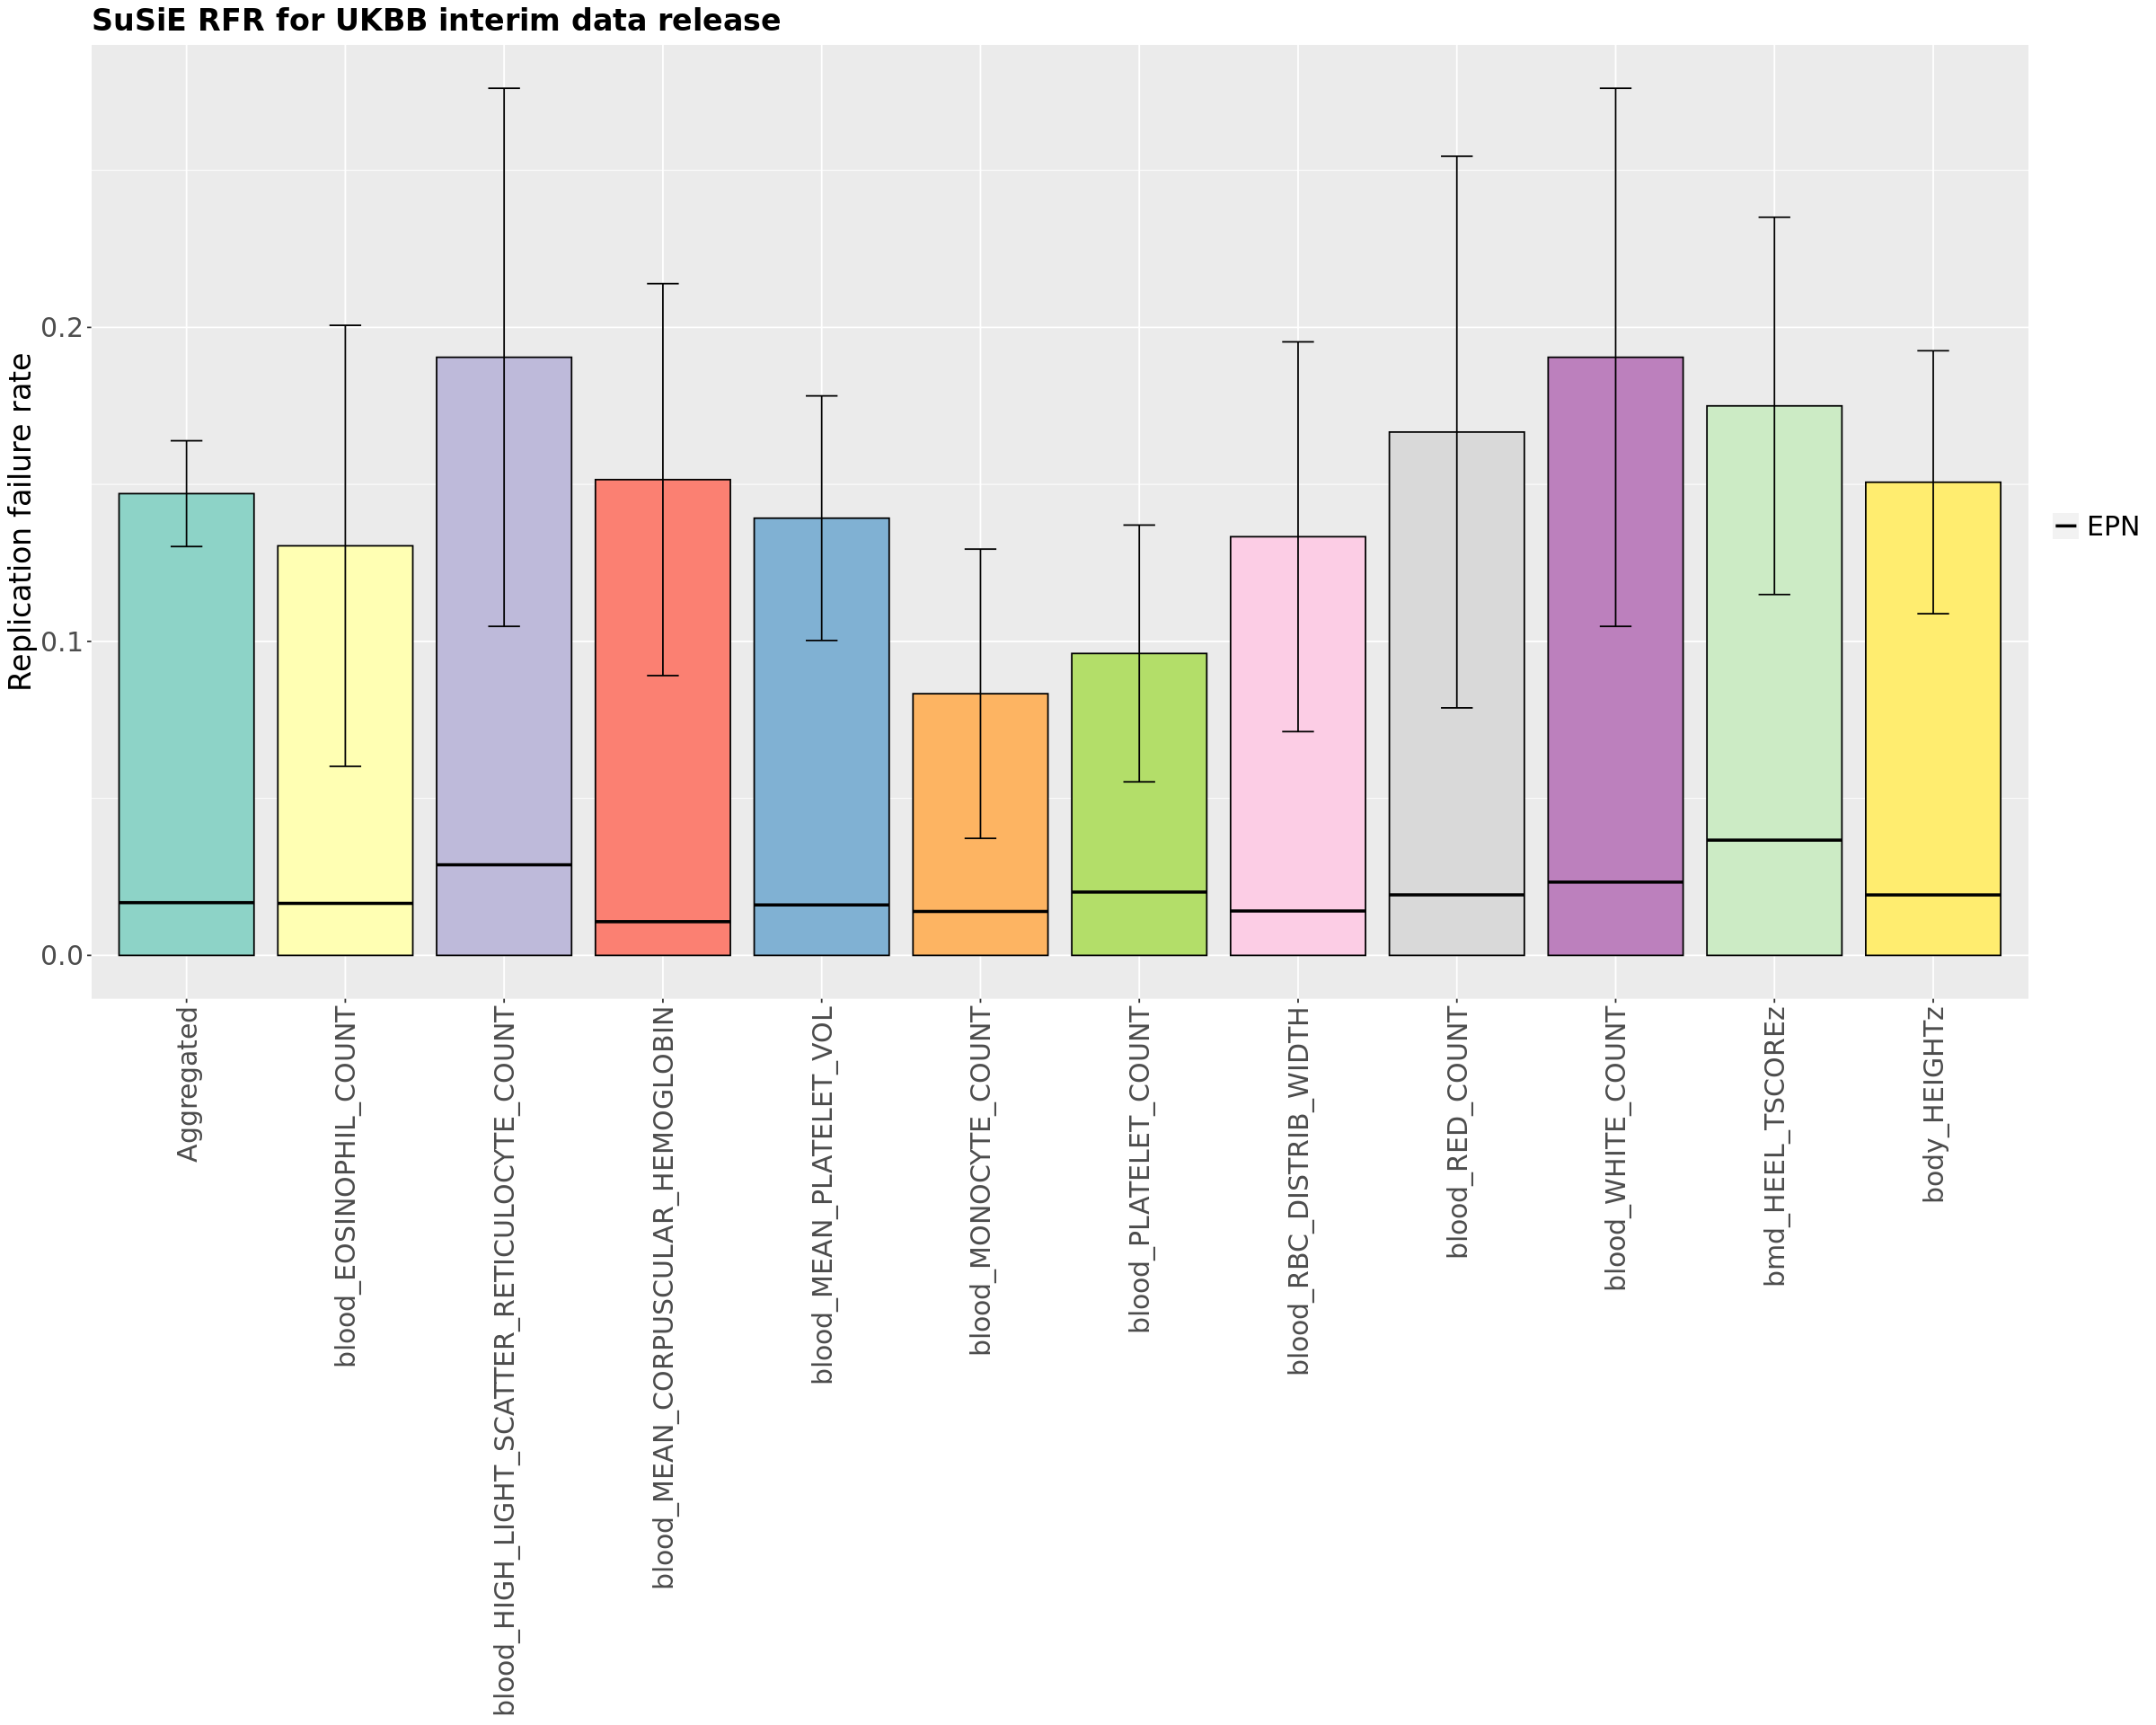

In [48]:
# Aggregated RFR plot
rfr_df = read_excel("Supplementary Tables.xlsx", sheet = 25)
all_rfr = rfr_df %>% dplyr::select('trait','n_highpip','n_nonrep','epn') %>% filter(n_highpip>15)
all_rfr[,c('mean','lower','upper')] = binom.confint(all_rfr$n_nonrep, all_rfr$n_highpip, 
                                                   conf.level=0.90, methods='exact')[,c('mean','lower','upper')]
all_rfr$segment_legend='EPN'
all_rfr$std = sqrt((all_rfr$mean)*(all_rfr$n_highpip)*(1-all_rfr$mean))/all_rfr$n_highpip

num_traits = length(unique(all_rfr$trait))
barwidth = 0.85 #0.85/num_traits
data_to_plot = all_rfr 

xstart = seq(1-barwidth/2,num_traits-barwidth/2,length.out=num_traits)
xend = seq(1-barwidth/2+barwidth,num_traits+barwidth/2,length.out=num_traits)

data_to_plot[data_to_plot=='agg'] = 'Aggregated'

pl_rfr = ggplot(data=data_to_plot, 
       aes(x=trait, y=mean, fill=trait)) +
    geom_bar(color='black', stat="identity",width=0.85, show.legend = FALSE) + 
    geom_segment(data=data_to_plot, aes(x=xstart, y=epn, 
                 xend=xend, yend=epn, 
                 color=trait,linetype=`segment_legend`), 
                 size=1,color='black',inherit.aes = FALSE)+
    geom_errorbar(aes(ymin=mean-std, ymax=mean+std),position=position_dodge(.85),width=0.2)+
    ylab(label = "Replication failure rate")+
    scale_linetype_manual("EPN",values=c("EPN"=1.5))+
    ggtitle('SuSiE RFR for UKBB interim data release') + scale_fill_brewer(palette="Set3") +
    pl_theme + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), 
                     legend.title=element_blank(), axis.title.x = element_blank())
options(repr.plot.width=20, repr.plot.height=16)
pl_rfr

# Supplementary Fig. 4

In [49]:
snp_properties_df = read_excel("Supplementary Tables.xlsx", sheet = 26)
column_names = c('MAF','INFO','chisq_ds','LDscore','prob_diff','prob_ds','exp_causal_100kb')
type_names = c('MAF','INFO','Chi-square','LDscore','PIP diff', 'PIP at 100K','Expected #causal within 100kb')
flip_status = c(TRUE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE)
make_rfr_df <- function(df,threshold_colname, type_name, flip){
    df_full_exist = df[!is.na(df$prob_full),]
    df_filtered = df_full_exist[!is.na(df_full_exist[threshold_colname]),]
    thresholds = quantile(df_filtered[,threshold_colname], probs=seq(0,1,0.1),na.rm=TRUE)
    rfr_df <- data.frame(matrix(ncol = 0, nrow = length(thresholds)))
    rfr_df$threshold = thresholds
    i = 1
    for (t in thresholds){
        if (flip){
            n_df = df_filtered[df_filtered[threshold_colname]<=t,]
        }
        else{
            n_df = df_filtered[df_filtered[threshold_colname]>=t,]
        }
        nonrep = n_df[n_df['prob_full']<=0.1,]
        rfr_df[i,'n_highpip'] = nrow(n_df)
        rfr_df[i,'n_nonrep'] = nrow(nonrep)
        rfr_df[i,'n_rep'] = nrow(n_df[n_df['prob_full']>=0.9,])
        i = i+1
    }
    rfr_df[,c('mean','lower','upper')] = binom.confint(rfr_df$n_nonrep,
                                                       rfr_df$n_highpip,
                                                       conf.level=0.95,
                                                       methods='exact')[,c('mean','lower','upper')]
    rfr_df$type = type_name
    return(rfr_df)
}
# SuSiE & FINEMAP aggregated
rfr_df_list = list()
for (i in 1:length(type_names)){
    rfr_df_list[[i]] = make_rfr_df(snp_properties_df,
                                   column_names[i],type_names[i],flip_status[i])
}
rfr_df_all = bind_rows(rfr_df_list)
rfr_df_all$type = factor(rfr_df_all$type, levels=type_names)
rfr_df_all = rfr_df_all %>% filter(n_rep>=50)
# plot
pl_snp_properties = ggplot(rfr_df_all, aes(x=n_rep, y=mean, group=type, color=type)) +
      geom_line(aes(color=type),size=1.5)+
      geom_point(size=2.5)+
    scale_color_brewer(palette="Set3")+
    ylab('Replication failure rate')+xlab('Number of replicated SNPs')+
    ggtitle(sprintf('%s RFR v.s. #replications','SuSiE&FINEMAP agg'))+
    pl_theme + theme(legend.title=element_blank())

New names:
• `` -> `...1`


In [50]:
recur_df = read_excel("Supplementary Tables.xlsx", sheet = 27)
pl_height10 <- ggplot(recur_df, aes(x=factor(type),y=n))+
 geom_dotplot(binaxis='y',stackdir = "center",binwidth=0.5)+
 ylab('# downsampling analyses')+
 ggtitle('Number of appearances in 10 Height downsampling analyses for non-replicating and replicated regions')+
 pl_theme+theme(axis.title.x=element_blank())+
scale_y_continuous(breaks = function(x) unique(floor(pretty(seq(0, (max(x) + 1) * 1.1)))))

New names:
• `` -> `...1`


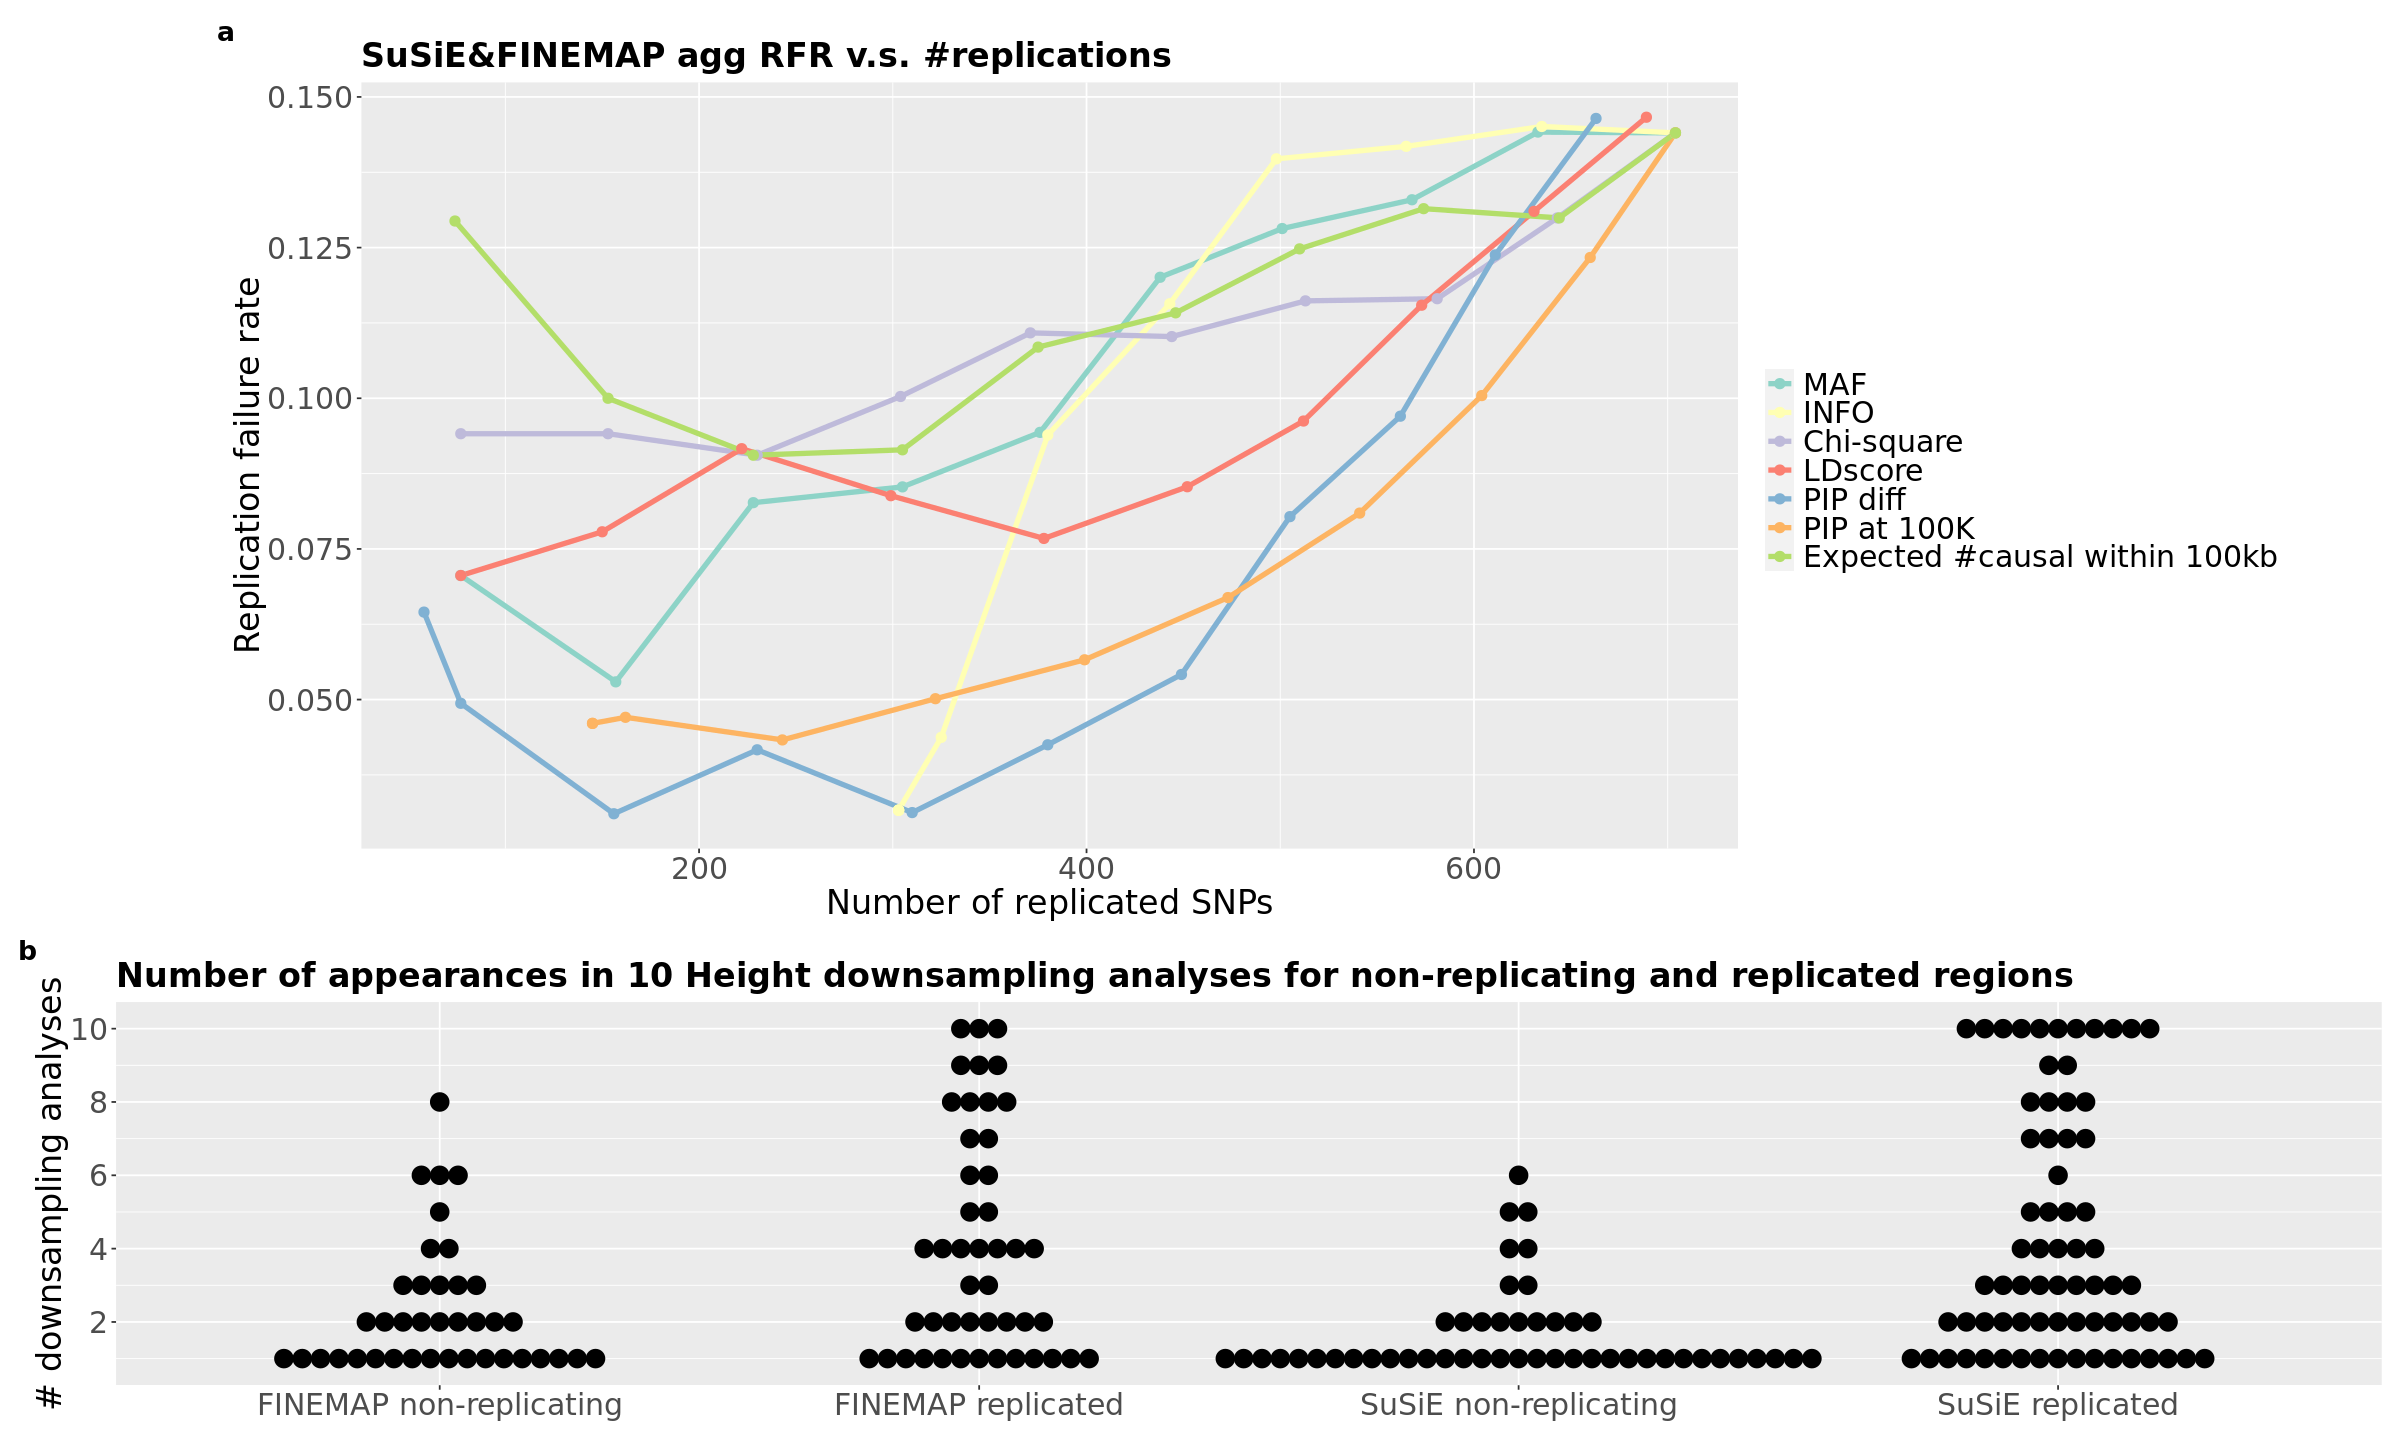

In [51]:
options(repr.plot.width=20, repr.plot.height=12)
layout <- "
#AAAAAAAAAAAAAAA#
#AAAAAAAAAAAAAAA#
BBBBBBBBBBBBBBBBB
"
supp_fig14 <- pl_snp_properties + pl_height10 + plot_layout(design = layout)+
 plot_annotation(tag_levels = "a") & theme(plot.tag = element_text(face = 'bold', size=16))
supp_fig14